In [3]:
import numpy as np
import numpy.random as npr
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import time
import networkx as nx
import networkx.algorithms.bipartite as bpt
import networkx.algorithms.isomorphism as iso
import scipy.sparse as sp
import sys

In [40]:
# Configure Matplotlib fonts to match IEEE template
plt.rcParams['font.family'] = 'serif'  # Set the main font family to serif
plt.rcParams['font.monospace'] = ['Courier']  # Use Courier for monospaced text
plt.rcParams['font.serif'] = ['Computer Modern', 'DejaVu Serif', 'Liberation Serif', 'Nimbus Roman']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'Liberation Sans', 'Nimbus Sans']
plt.rc('text', usetex=True)

### Graph manipulation utilities

In [4]:
def load_tanner_graph(filename, show_matrix=False):
    m, n = np.loadtxt(filename, max_rows=1, dtype=int)
    indices, indptr = np.array([], dtype=int), [0]
    for r in range(m):
        r_ind = np.loadtxt(filename, skiprows=r+1, max_rows=1, dtype=int)
        indices = np.concatenate([indices, np.sort(r_ind)])
        indptr.append(len(r_ind))
    
    H = sp.csr_array((m, n), dtype=int)
    H.data = np.ones_like(indices, dtype=int)
    H.indices = indices
    H.indptr = np.cumsum(indptr)

    if show_matrix:
        return bpt.from_biadjacency_matrix(H, create_using=nx.MultiGraph), H
    return bpt.from_biadjacency_matrix(H, create_using=nx.MultiGraph)

def graph_transpose(G: nx.Graph) -> nx.Graph:
    a = [n for n, b in G.nodes(data='bipartite') if b == 0]
    return bpt.from_biadjacency_matrix(bpt.biadjacency_matrix(G, row_order=a).T, create_using=nx.Graph)

### Visualization utilities

In [35]:
def draw_bpt_graph(G: nx.MultiGraph, ax=None, highlight_edges=None):
    checks = [n for n, b in G.nodes(data='bipartite') if b == 0]
    bits = [n for n, b in G.nodes(data='bipartite') if b == 1]
    pos = nx.layout.bipartite_layout(G, checks)
    
    # Draw the graph
    if ax is None:
        plt.figure(figsize=(5, 4))
        
    if highlight_edges is None:
        nx.draw_networkx_nodes(G, pos, ax=ax, alpha=0.7,
                               node_color=['grey' if n in checks else 'purple' for n in G.nodes])
        nx.draw_networkx_labels(G, pos, ax=ax,
                                labels={n: ('$c_{%}$'.replace('%', str(n+1)) if n in checks \
                            else '$n_{%}$'.replace('%', str(n+1-len(checks)))) for n in G.nodes})
        nx.draw_networkx_edges(G, pos, ax=ax,
                edge_color=[u%10 for (u, *_) in G.edges(data=False)], 
                edge_cmap=plt.cm.tab10, edge_vmin=0, edge_vmax=9)
    else:
        nx.draw_networkx_nodes(G, pos, ax=ax, alpha=0.7,
                               node_color=['grey' if n in checks else 'purple' for n in G.nodes])
        nx.draw_networkx_labels(G, pos, ax=ax,
                                labels={n: ('$c_{%}$'.replace('%', str(n+1)) if n in checks \
                            else '$n_{%}$'.replace('%', str(n+1-len(checks)))) for n in G.nodes})
        nx.draw_networkx_edges(G, pos, ax=ax,
                edge_color=[u%10 for (u, *_) in G.edges(data=False)], 
                edge_cmap=plt.cm.tab10, edge_vmin=0, edge_vmax=9, alpha=0.5, width=1)
        nx.draw_networkx_edges(G, pos, edgelist=highlight_edges, ax=ax, width=4, edge_color='crimson')
        nx.draw_networkx_edges(G, pos, edgelist=highlight_edges, ax=ax, width=2, edge_color='gold')
        nx.draw_networkx_edges(G, pos, edgelist=highlight_edges, ax=ax, width=0.5, edge_color='ivory')

        
    if ax is None:
        plt.show()

def split_linear_bpt_layout(G: nx.graph, flip: bool=False) -> dict[int: float]:
    l, h = -1, 1
    box = (h-l)/G.number_of_nodes()
    if flip:
        c = [n for n, b in G.nodes(data='bipartite') if b == 0]
        v = [n for n, b in G.nodes(data='bipartite') if b == 1]
        flip_c = lambda n: len(c)-1 - n
        flip_v = lambda n: len(v)-1 - (n - len(c)) + len(c)
        return {n: flip_c(n)*box + box/4 if b == 0 else flip_v(n)*box + box*3/4 for n, b in G.nodes(data='bipartite')}
    else:
        return {n: n*box + box/4 if b == 0 else n*box + box*3/4 for n, b in G.nodes(data='bipartite')}
    
def hgp_layout(G1: nx.Graph, G2: nx.Graph) -> dict[int: float]:
    # Assume G1 = (C1 u V1, E1), G2 = (C2 u V2, E2)
    # Display H = HGP(G1, G2) as
    # C1xC2 V1xC2
    # C1xV2 V1xV2
    h_layout = split_linear_bpt_layout(G1)
    v_layout = split_linear_bpt_layout(G2, flip=False)
    
    return {(n1, n2): np.array([h_layout[n1]-1, 1-v_layout[n2]]) \
            for n1 in G1.nodes for n2 in G2.nodes}

def draw_hgp_graph(G: nx.Graph, nodesize:int=500, fontsize:int=8, ax=None):
    # Gt = graph_transpose(G)
    c = [n for n, b in G.nodes(data='bipartite') if b == 0]
    v = [n for n, b in G.nodes(data='bipartite') if b == 1]
    # vt = [n for n, b in Gt.nodes(data='bipartite') if b == 0]
    # ct = [n for n, b in Gt.nodes(data='bipartite') if b == 1]
    
    HGP = nx.cartesian_product(G, G)
    
    X_pos, X_neg, Z_pos, Z_neg = [], [], [], []
    
    for (x1, y1), (x2, y2) in HGP.edges(data=False):
        if y1 == y2 and y1 in c:
            Z_neg.append(((x1, y1), (x2, y2)))
        if x1 == x2 and x1 in c:
            X_neg.append(((x1, y1), (x2, y2)))
        if x1 == x2 and x1 in v:
            Z_pos.append(((x1, y1), (x2, y2)))
        if y1 == y2 and y1 in v:
            X_pos.append(((x1, y1), (x2, y2)))
    
    V, C = bpt.sets(HGP)
    V = [n for n, b in HGP.nodes(data='bipartite') if b[0] == b[1]]
    C = [n for n, b in HGP.nodes(data='bipartite') if b[0] != b[1]]
    pos = hgp_layout(G, G)
    
    if ax is None:
        plt.figure(figsize=(8,8))
        
    nx.draw_networkx_edges(HGP, pos, edgelist=X_pos, arrows=True, ax=ax,
                           connectionstyle='arc3,rad=+0.3', edge_color='b')
    nx.draw_networkx_edges(HGP, pos, edgelist=Z_pos, arrows=True, ax=ax, 
                           connectionstyle='arc3,rad=-0.3', edge_color='r')
    nx.draw_networkx_edges(HGP, pos, edgelist=Z_neg, arrows=True, ax=ax, 
                           connectionstyle='arc3,rad=-0.3', edge_color='r')
    nx.draw_networkx_edges(HGP, pos, edgelist=X_neg, arrows=True, ax=ax, 
                           connectionstyle='arc3,rad=+0.3', edge_color='b')
    nx.draw_networkx_nodes(HGP, pos, nodelist=C, node_color='grey', 
                           node_shape='s', node_size=nodesize, ax=ax)
    nx.draw_networkx_nodes(HGP, pos, nodelist=V, node_color='purple', 
                           node_shape='o', node_size=nodesize, ax=ax)
    
    parse_label = lambda nn: ('$c_{%} '.replace('%', str(1+nn[1])) if nn[1] in c else \
               '$v_{%} '.replace('%', str(1+nn[1] - len(c)))) + (
                'c_{%}$'.replace('%', str(1+nn[0])) if nn[0] in c else \
               'v_{%}$'.replace('%', str(1+nn[0] - len(c))))
    nx.draw_networkx_labels(HGP, pos, labels={nn: parse_label(nn) for nn in HGP.nodes}, 
                           font_size=fontsize, ax=ax)
    if ax is None:
        plt.annotate('$X$', (-1.25, -1.15), color='b', fontsize=24)
        plt.annotate('$Z$', (+1.1, +1.05), color='r', fontsize=24)
        plt.show()
    else:
        ax.annotate('$X$', (-1.25, -1.15), color='b', fontsize=24)
        ax.annotate('$Z$', (+1.1, +1.05), color='r', fontsize=24)


### Draft: comparing C++ vs Python implementation of MAP decoder

In [7]:
import pym4ri as m4ri
from css_code_eval import CSS_HGP_code_from_state
import css_code_eval as css

In [8]:
def MC_erasure_plog(num_trials: int, state: nx.MultiGraph, p_vals: list[float]=None) -> dict:
    # Compute CSS code for the HGP induced by the state
    H, N_qubits, _ = CSS_HGP_code_from_state(state)
    Hx, Hz = np.vsplit(H.todense(), 2)

    # Compute the parity-check matrices of Cz^\perp and Cx^\perp
    etaHz = m4ri.gen2chk(Hz)
    etaHx = m4ri.gen2chk(Hx)

    # Register mean and std of the Monte Carlo estimates
    est_plog = {'mean': [], 'std': []}

    for p in p_vals:
        trials = []
        for _ in range(num_trials):
            # IID erasure with probability p (physical error rate)
            E = npr.rand(N_qubits) < p

            # Generate the Cx and Cz intersections with the erasure support
            gammaHxE = m4ri.chk2gen(Hx[:, E])
            gammaHzE = m4ri.chk2gen(Hz[:, E])

            # Check for the existence of logical errors hiding in the erasure
            z_logical_error = m4ri.gf2_mul(etaHz[:, E], gammaHxE).any()
            x_logical_error = m4ri.gf2_mul(etaHx[:, E], gammaHzE).any()

            # Failure criterion: the erasure hides a logical error of either type
            failure = z_logical_error or x_logical_error
            trials.append(1. if failure else 0.)

        trials = np.array(trials)
        est_plog['mean'].append(trials.mean())
        est_plog['std'].append(trials.std())

    return est_plog


In [9]:
codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
textfiles = ["../initial_codes/"+f"HGP_(3,4)_{code}.txt" for code in codes]

new_state = load_tanner_graph(textfiles[0])
num_trials = int(1e4)
p_vals = np.linspace(1e-1, 3e-1, 11)
# p_vals = [0.8]

In [22]:
# Exact or eta-gamma approach
print(f"Method: Eta-Gamma approach\n{num_trials = }, {len(p_vals) = }")

print("Python version")
%timeit plain_MC = MC_erasure_plog(num_trials, new_state, p_vals)

print("C version")
%timeit results = css.MC_erasure_plog(num_trials, new_state, p_vals)

Method: Eta-Gamma approach
num_trials = 1000, len(p_vals) = 1
Python version
6.57 s ± 1.2 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
C version
2.51 s ± 139 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
MC_py = MC_erasure_plog(num_trials, new_state, p_vals)
MC_C = css.MC_erasure_plog(num_trials, new_state, p_vals)

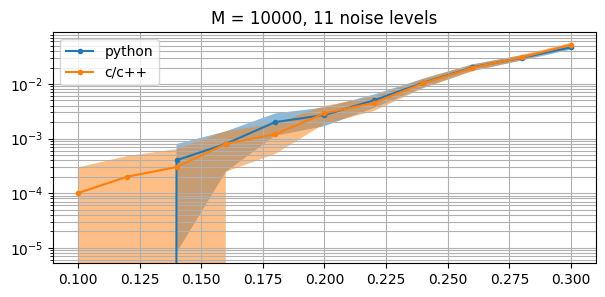

In [34]:
plt.figure(figsize=(7, 3))
plt.title(f"M = {num_trials}, {len(p_vals)} noise levels")

for data, name in zip([MC_py, MC_C], 
                      ['python', 'c/c++']):
    m = np.array(data['mean'])
    s = np.array(data['std'])
    plt.semilogy(p_vals, m, '.-', label=name)
    plt.fill_between(p_vals, m - 1.96*s/np.sqrt(num_trials), 
                     m + 1.96*s/np.sqrt(num_trials), alpha=0.5)
    

plt.legend()
plt.grid(which='both')
plt.show()

# Graph Visualizations

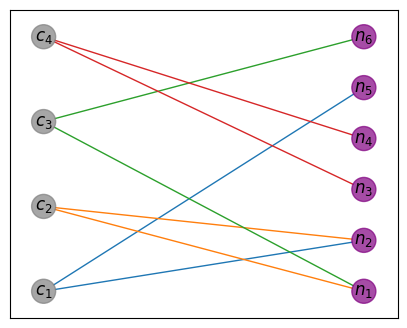

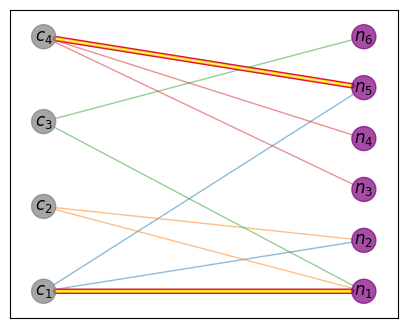

In [11]:
G = bpt.configuration_model(aseq=[2, 2, 2, 2], 
                            bseq=[2, 2, 1, 1, 1, 1], 
                            create_using=nx.MultiGraph())
draw_bpt_graph(G)
draw_bpt_graph(G, highlight_edges=[(0, 4), (3, 8)])

In [13]:
checks = [n for n, b in G.nodes(data='bipartite') if b == 0]
bits = [n for n, b in G.nodes(data='bipartite') if b == 1]
pos = nx.layout.bipartite_layout(G, checks)

print(r'\begin{tikzpicture}[scale=5]')
for node, p in pos.items():
    p[0] = -0.5 if node in checks else 0.5
    p[1] *= -1
    color = 'gray' if node in checks else 'violet'
    label = f'$c_{node+1}$' if node in checks else f'$v_{node+1-len(checks)}$'
    print(f'\t\\node[fill={color}!50, circle, draw, text=black] ({node}) at ({p[0]:.1f},{p[1]:.3f}) {{{label}}};')

for edge in G.edges():
    print(f'\t\\draw ({edge[0]}) -- ({edge[1]});')

print(r'\end{tikzpicture}')

\begin{tikzpicture}[scale=5]
	\node[fill=gray!50, circle, draw, text=black] (0) at (-0.5,0.625) {$c_1$};
	\node[fill=gray!50, circle, draw, text=black] (1) at (-0.5,0.208) {$c_2$};
	\node[fill=gray!50, circle, draw, text=black] (2) at (-0.5,-0.208) {$c_3$};
	\node[fill=gray!50, circle, draw, text=black] (3) at (-0.5,-0.625) {$c_4$};
	\node[fill=violet!50, circle, draw, text=black] (4) at (0.5,0.625) {$v_1$};
	\node[fill=violet!50, circle, draw, text=black] (5) at (0.5,0.375) {$v_2$};
	\node[fill=violet!50, circle, draw, text=black] (6) at (0.5,0.125) {$v_3$};
	\node[fill=violet!50, circle, draw, text=black] (7) at (0.5,-0.125) {$v_4$};
	\node[fill=violet!50, circle, draw, text=black] (8) at (0.5,-0.375) {$v_5$};
	\node[fill=violet!50, circle, draw, text=black] (9) at (0.5,-0.625) {$v_6$};
	\draw (0) -- (8);
	\draw (0) -- (5);
	\draw (1) -- (4);
	\draw (1) -- (5);
	\draw (2) -- (4);
	\draw (2) -- (9);
	\draw (3) -- (6);
	\draw (3) -- (7);
\end{tikzpicture}


In [14]:
pos = nx.layout.bipartite_layout(G, checks)
G = nx.Graph(G)
# F = nx.to_latex(G, pos=pos, 
#             node_label={v: ('$c_{%}$'.replace('%', str(v+1)) if b==0 \
#                             else '$n_{%}$'.replace('%', str(v+1-len(checks)))) for v, b in G.nodes(data='bipartite')}, 
#             edge_options='edge_options', 
#             n_rows=1, as_document=False)


In [15]:
from pym4ri import chk2gen

In [16]:
H = np.array([
[1, 1, 1, 0, 1, 0, 0,],
[0, 1, 1, 1, 0, 1, 0,],
[0, 0, 1, 0, 1, 1, 1,],
])
G = bpt.from_biadjacency_matrix(sp.csr_array(H))

In [17]:
chk2gen(H.astype(bool)).astype(int)

array([[1, 1, 1, 0],
       [1, 1, 0, 1],
       [0, 1, 1, 1],
       [1, 0, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

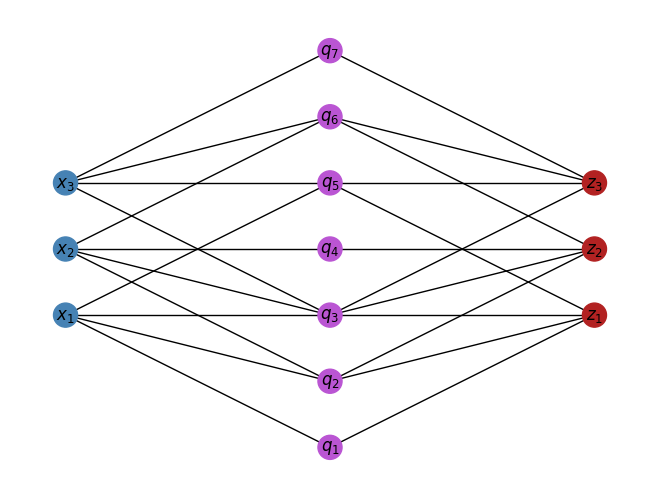

In [18]:
m, n = H.shape
sp.dok_array(H).keys()
x_labels = lambda c, v: (f'$x_{{{c+1}}}$', f'$q_{{{v+1}}}$')
z_labels = lambda c, v: (f'$z_{{{c+1}}}$', f'$q_{{{v+1}}}$')
x_edges = [x_labels(*e) for e in sp.dok_array(H).keys()]
z_edges = [z_labels(*e) for e in sp.dok_array(H).keys()]
Q = nx.Graph()
q_nodes = [f'$q_{{{v+1}}}$' for v in range(n)]
x_nodes = [f'$x_{{{c+1}}}$' for c in range(m)]
z_nodes = [f'$z_{{{c+1}}}$' for c in range(m)]
Q.add_nodes_from(x_nodes, layer=0)
Q.add_nodes_from(q_nodes, layer=1)
Q.add_nodes_from(z_nodes, layer=2)
Q.add_edges_from(x_edges)
Q.add_edges_from(z_edges)

pos = nx.multipartite_layout(Q, subset_key='layer')
for lbl, p in zip(q_nodes, np.sort([pos[lbl] for lbl in q_nodes], axis=0)):
    pos[lbl] = p
for lbl, p in zip(x_nodes, np.sort([pos[lbl] for lbl in x_nodes], axis=0)):
    pos[lbl] = p
for lbl, p in zip(z_nodes, np.sort([pos[lbl] for lbl in z_nodes], axis=0)):
    pos[lbl] = p

colors = ['steelblue', 'mediumorchid', 'firebrick']
nx.draw(Q, pos, node_color=[colors[l] for v, l in Q.nodes(data='layer')],
        with_labels=True)
plt.show()

In [19]:
import matplotlib.colors as mplcolors
torgb = lambda colorname: [int(255*t) for t in mplcolors.to_rgb(colorname)]
colors = ['steelblue', 'mediumorchid', 'firebrick']

In [20]:
print(r'\begin{tikzpicture}[scale=5]')
for label, p in pos.items():
    l = Q.nodes(data='layer')[label]
    p[0] = [-0.67, 0, +0.67][l]
    p[1] *= -1
    color = colors[l]
    lbl2node = lambda lbl: lbl[1]+lbl.split(r'{')[-1].split(r'}')[0]
    node = lbl2node(label)
    r, g, b = torgb(color)
    print(f'\t\\node[fill={{rgb:red,{r};green,{g};blue,{b}}}, fill opacity=0.75, circle, draw, text=black, text opacity=1] ({node}) at ({p[0]:.2f},{p[1]:.3f}) {{{label}}};')

for edge in Q.edges():
    print(f'\t\\draw ({lbl2node(edge[0])}) -- ({lbl2node(edge[1])});')

print(r'\end{tikzpicture}')

\begin{tikzpicture}[scale=5]
	\node[fill={rgb:red,70;green,130;blue,180}, fill opacity=0.75, circle, draw, text=black, text opacity=1] (x2) at (-0.67,-0.000) {$x_{2}$};
	\node[fill={rgb:red,70;green,130;blue,180}, fill opacity=0.75, circle, draw, text=black, text opacity=1] (x3) at (-0.67,-0.333) {$x_{3}$};
	\node[fill={rgb:red,70;green,130;blue,180}, fill opacity=0.75, circle, draw, text=black, text opacity=1] (x1) at (-0.67,0.333) {$x_{1}$};
	\node[fill={rgb:red,186;green,85;blue,211}, fill opacity=0.75, circle, draw, text=black, text opacity=1] (q4) at (0.00,-0.000) {$q_{4}$};
	\node[fill={rgb:red,186;green,85;blue,211}, fill opacity=0.75, circle, draw, text=black, text opacity=1] (q1) at (0.00,1.000) {$q_{1}$};
	\node[fill={rgb:red,186;green,85;blue,211}, fill opacity=0.75, circle, draw, text=black, text opacity=1] (q2) at (0.00,0.667) {$q_{2}$};
	\node[fill={rgb:red,186;green,85;blue,211}, fill opacity=0.75, circle, draw, text=black, text opacity=1] (q5) at (0.00,-0.333) {$q_{5}$}

# Cross-wiring edges

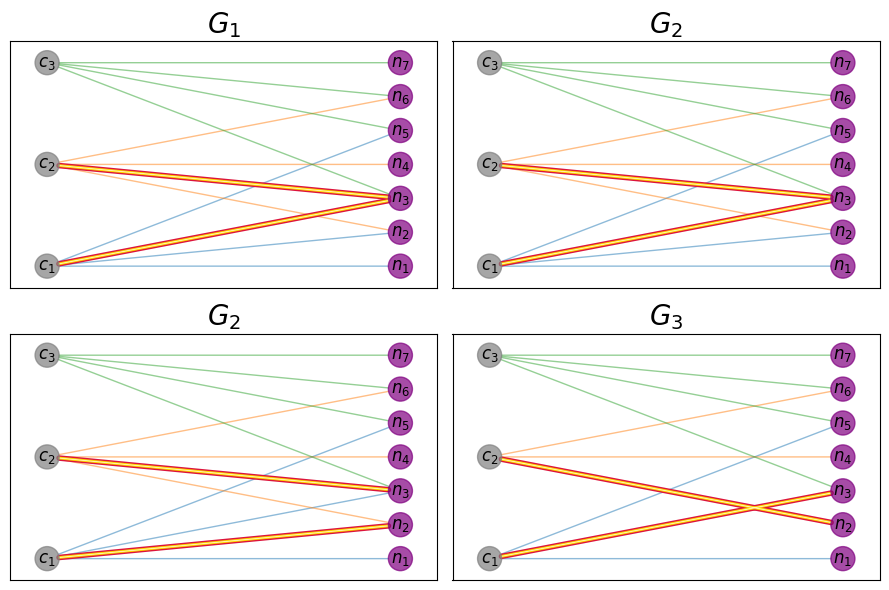

[(0, 3), (0, 4), (0, 5), (0, 7), (1, 4), (1, 5), (1, 6), (1, 8), (2, 5), (2, 7), (2, 8), (2, 9)]
[(0, 3), (0, 4), (0, 5), (0, 7), (1, 4), (1, 5), (1, 6), (1, 8), (2, 5), (2, 7), (2, 8), (2, 9)]
[(0, 3), (0, 5), (0, 5), (0, 7), (1, 4), (1, 4), (1, 6), (1, 8), (2, 5), (2, 7), (2, 8), (2, 9)]


In [23]:
from experiments_settings import generate_neighbor_highlight

fig, ((ax0, ax11), (ax12, ax2)) = plt.subplots(2, 2, figsize=(9, 6))

m, n, k = 3, 6, 2

G0 = nx.MultiGraph(G)
G1, pair0, pair11 = generate_neighbor_highlight(G0)
G2, pair12, pair2 = generate_neighbor_highlight(G1)

fs = 20

ax0.set_title('$G_1$', fontsize=fs)
draw_bpt_graph(G0, ax=ax0, highlight_edges=pair0)

ax11.set_title('$G_2$', fontsize=fs)
draw_bpt_graph(G1, ax=ax11, highlight_edges=pair11)
ax12.set_title('$G_2$', fontsize=fs)
draw_bpt_graph(G1, ax=ax12, highlight_edges=pair12)

ax2.set_title('$G_3$', fontsize=fs)
draw_bpt_graph(G2, ax=ax2, highlight_edges=pair2)

plt.tight_layout()


plt.show()

print(sorted(G0.edges(data=False)))
print(sorted(G1.edges(data=False)))
print(sorted(G2.edges(data=False)))

In [24]:
bpt.biadjacency_matrix(G1, row_order=np.arange(m)).astype(np.uint8).todense()

array([[1, 1, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 1, 1]], dtype=uint8)

In [25]:
matr = bpt.biadjacency_matrix(G1, row_order=np.arange(m)).astype(np.uint8)

In [26]:
np.diff(matr.indptr).astype(bool).sum()
matr.todense()

array([[1, 1, 1, 0, 1, 0, 0],
       [0, 1, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 1, 1]], dtype=uint8)

# State Representation and Indexing

In order to keep track of the visited states and map their representation to the corresponding PS structures (namely, the $h$ and $g$ matrices, and a reward cache), we'll introduce the StateIndexer class. 

Since the error correcting properties of a code are invariant by graph isomorphism of its Tanner graph (equivalently, by permutation of the qubits and of the check nodes), it might be interesting to index states by taking into account isomorphism equivalence classes. One way to do it is via Graph Canonization. 

In [27]:
from state_indexer import GraphSerializer

## Testing:

### Serialization/Deserialization

In [28]:
# Create a random graph from its biadjacency matrix. Let's allow for a few multiedges. 
m, n = (3, 7)
x = npr.randint(0, 3, (3, 7), dtype=np.uint8)
G = bpt.from_biadjacency_matrix(sp.csr_matrix(x), create_using=nx.MultiGraph())
x, G.edges

(array([[2, 2, 1, 1, 0, 2, 2],
        [2, 1, 1, 1, 2, 2, 1],
        [2, 0, 0, 1, 1, 2, 1]], dtype=uint8),
 MultiEdgeView([(0, 3, 0), (0, 3, 1), (0, 4, 0), (0, 4, 1), (0, 5, 0), (0, 6, 0), (0, 8, 0), (0, 8, 1), (0, 9, 0), (0, 9, 1), (1, 3, 0), (1, 3, 1), (1, 4, 0), (1, 5, 0), (1, 6, 0), (1, 7, 0), (1, 7, 1), (1, 8, 0), (1, 8, 1), (1, 9, 0), (2, 3, 0), (2, 3, 1), (2, 6, 0), (2, 7, 0), (2, 8, 0), (2, 8, 1), (2, 9, 0)]))

In [29]:
# Now serialize it and then deserialize it
state_indexer = GraphSerializer(graph_dims=(m, n))
d_serial = state_indexer.serialize_dense(G)
s_serial = state_indexer.serialize_sparse(G)
d_serial, s_serial

(b'\x02\x02\x01\x01\x00\x02\x02\x02\x01\x01\x01\x02\x02\x01\x02\x00\x00\x01\x01\x02\x01',
 b'\x00\x03\x00\x03\x00\x04\x00\x04\x00\x05\x00\x06\x00\x08\x00\x08\x00\t\x00\t\x01\x03\x01\x03\x01\x04\x01\x05\x01\x06\x01\x07\x01\x07\x01\x08\x01\x08\x01\t\x02\x03\x02\x03\x02\x06\x02\x07\x02\x08\x02\x08\x02\t')

In [30]:
rec_G_d = state_indexer.deserialize_dense(d_serial)
rec_G_s = state_indexer.deserialize_sparse(s_serial)
assert rec_G_d.__class__ == nx.MultiGraph
assert rec_G_s.__class__ == nx.MultiGraph
assert (x == bpt.biadjacency_matrix(rec_G_d, row_order=np.arange(m)).astype(np.uint8).todense()).all()
assert (x == bpt.biadjacency_matrix(rec_G_s, row_order=np.arange(m)).astype(np.uint8).todense()).all()
assert nx.utils.graphs_equal(rec_G_d, G)
assert nx.utils.graphs_equal(rec_G_s, G)

AssertionError: 

## Graph Canonization

In [5]:
import pynauty as nauty

In [29]:
def nx_to_nauty(G: nx.MultiGraph) -> nauty.Graph:
    Gs = nx.Graph(G)
    c = {n for n, b in Gs.nodes(data='bipartite') if b == 0}
    v = {n for n, b in Gs.nodes(data='bipartite') if b == 1}
    g = nauty.Graph(number_of_vertices=Gs.number_of_nodes(), directed=True,
                    adjacency_dict={n: list(Gs.neighbors(n)) if n in v else [] for n in Gs.nodes})
    return nauty.certificate(g)

    
def canonize(G: nx.MultiGraph) -> nx.MultiGraph:
    E = G.number_of_edges()
    Gs = nx.Graph(G)
    c = {n for n, b in Gs.nodes(data='bipartite') if b == 0}
    v = {n for n, b in Gs.nodes(data='bipartite') if b == 1}
    Gnauty = nauty.Graph(number_of_vertices=Gs.number_of_nodes(), directed=True, 
                         adjacency_dict={n: list(Gs.neighbors(n)) if n in v else [] for n in Gs.nodes})
    new_labels = nauty.canon_label(Gnauty)
    mapping = {new_labels[k]: k for k in range(Gs.number_of_nodes())}
    # print(mapping)
    new_edges = sorted([(mapping[u], mapping[v]) for u, v in Gs.edges(data=False)])

    Gcanon = nx.MultiGraph()
    Gcanon.add_nodes_from(c, bipartite=0)
    Gcanon.add_nodes_from(v, bipartite=1)
    if len(new_edges) < E:
        new_edges = [new_edges[0]]*(E - len(new_edges)) + new_edges
    
    Gcanon.add_edges_from(new_edges)
    return Gcanon

[(0, 21, 0), (0, 10, 0), (1, 19, 0), (1, 10, 0), (2, 12, 0), (2, 18, 0), (3, 17, 0), (3, 14, 0), (4, 18, 0), (4, 19, 0), (4, 22, 0), (5, 13, 0), (5, 11, 0), (5, 16, 0), (6, 22, 0), (6, 20, 0), (7, 17, 0), (7, 11, 0), (8, 21, 0), (8, 15, 0), (8, 18, 0), (9, 20, 0)]
[(0, 13, 0), (0, 19, 0), (0, 22, 0), (1, 14, 0), (1, 22, 0), (2, 20, 0), (2, 21, 0), (2, 22, 0), (3, 10, 0), (3, 11, 0), (3, 15, 0), (4, 12, 0), (4, 16, 0), (5, 15, 0), (5, 16, 0), (6, 17, 0), (6, 19, 0), (7, 17, 0), (7, 20, 0), (8, 18, 0), (8, 21, 0), (9, 18, 0)]
[(0, 13, 0), (0, 19, 0), (0, 22, 0), (1, 14, 0), (1, 22, 0), (2, 20, 0), (2, 21, 0), (2, 22, 0), (3, 10, 0), (3, 11, 0), (3, 15, 0), (4, 12, 0), (4, 16, 0), (5, 15, 0), (5, 16, 0), (6, 17, 0), (6, 19, 0), (7, 17, 0), (7, 20, 0), (8, 18, 0), (8, 21, 0), (9, 18, 0)]


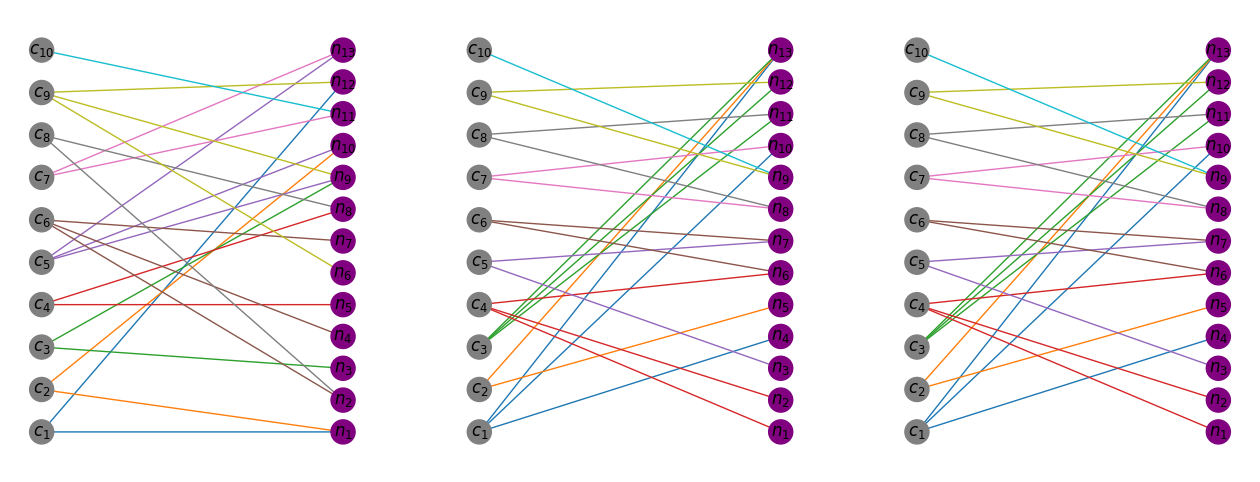

In [27]:
G = bpt.configuration_model(aseq=[2, 2, 2, 2, 3, 3, 2, 2, 3, 1], 
                            bseq=[2, 2, 1, 1, 1, 1, 1, 2, 3, 2, 2, 2, 2], 
                            create_using=nx.MultiGraph())
fig, axs = plt.subplots(1, 3, figsize=(16, 6))

Gc = canonize(G)
Gcc = canonize(Gc)

draw_bpt_graph(G, axs[0])
draw_bpt_graph(Gc, axs[1])
draw_bpt_graph(Gcc, axs[2])

print(G.edges)
print(Gc.edges)
print(Gcc.edges)

In [28]:
%timeit Gc = canonize(G)

7.56 s ± 245 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%timeit nx_to_nauty(G)

7.44 s ± 224 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# G = load_tanner_graph(path_to_initial_codes+textfiles[0])
# fig, axs = plt.subplots(1, 3, figsize=(16, 6))

# Gc = canonize(G)
# Gcc = canonize(Gc)

# draw_bpt_graph(G, axs[0])
# draw_bpt_graph(Gc, axs[1])
# draw_bpt_graph(Gcc, axs[2])

# print(G.edges)
# print(Gc.edges)
# print(Gcc.edges)

# Sparse Matrix formats

In [229]:
# %%timeit
S, A = 7, 30
h = sp.csr_array((S, A), dtype=np.float32)
g = sp.dok_array((S, A), dtype=np.float32)

gamma = 1e-3
eta = 1e-2
reward = 1

num_steps = 100
for _ in range(num_steps):
    h *= 1-gamma
    h += reward*g
    g *= 1-eta
    i, j = npr.randint(0, S), npr.randint(0, A)
    g[i, j] = 1

In [230]:
h.__dict__

{'_shape': (7, 30),
 'maxprint': 50,
 'indices': array([ 7,  2, 27, 28, 24, 21, 19, 10, 25,  4, 24,  8, 20,  6, 17, 15,  0,
        21, 27,  7,  3, 28, 19, 13,  1, 20, 29, 19,  9,  6, 17, 24, 11,  8,
        27,  5, 17, 22,  0, 11,  9,  4,  8, 18, 12, 10, 21,  7,  1,  2,  9,
        19, 27, 14, 15,  3, 17, 10, 29,  2, 21,  8,  4, 18,  1,  6, 14, 10,
        17,  3, 27, 29, 14,  6,  7, 11,  2, 25, 20,  1, 24], dtype=int32),
 'indptr': array([ 0,  8, 23, 35, 49, 59, 70, 81], dtype=int32),
 'data': array([18.831207 , 58.397495 , 51.21117  , 46.773674 , 41.767956 ,
        37.313423 , 25.752487 ,  5.837204 , 10.412954 , 12.172966 ,
        26.350801 , 27.75468  , 43.33285  , 46.299633 , 56.92133  ,
        43.842205 , 41.792587 , 28.444656 , 27.056755 , 18.03133  ,
        11.297879 ,  9.51809  ,  1.9890001, 17.772974 , 20.404112 ,
        24.406725 , 34.309803 , 40.14647  , 58.651554 , 53.234306 ,
        56.22057  , 58.88168  , 44.842857 , 47.821476 , 34.924595 ,
        41.079227 , 41.2

In [231]:
h.resize((30, 35))
h

<30x35 sparse array of type '<class 'numpy.float32'>'
	with 81 stored elements in Compressed Sparse Row format>

In [232]:
sp.csr_array(h.todense())

<30x35 sparse array of type '<class 'numpy.float32'>'
	with 81 stored elements in Compressed Sparse Row format>

In [108]:
# csc/csc = 319ms +- 7.57ms
# coo/dok = 448ms +- 8.85ms
# csc/dok = 495ms +- 14.4ms
# csr/dok = 464ms +- 17.6ms
# lil/dok = 19.2s +- 1.67s
# lil/lil = 27s +- 82.5ms

# Decoding the HGP code

## Visualizing HGP codes

In [34]:
from agent import PSAgent
from rl_environment import QECEnv

In [35]:
d_m, d_n = 4, 3
E = 1*np.lcm(d_m, d_n)
m, n = E//d_m, E//d_n
env = QECEnv(initial_state=G, plog_threshold=1.)

In [36]:
# Exact or eta-gamma approach
print(f"Method: Eta-Gamma approach\n{num_trials = }, {p_vals.size = }")

print("Python version")
%timeit plain_MC = MC_erasure_plog(num_trials, env.state, p_vals)

print("C version")
%timeit results = css.MC_erasure_plog(num_trials, env.state, p_vals)

Method: Eta-Gamma approach
num_trials = 10000, p_vals.size = 11
Python version
3.06 s ± 158 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
C version
1.3 s ± 161 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


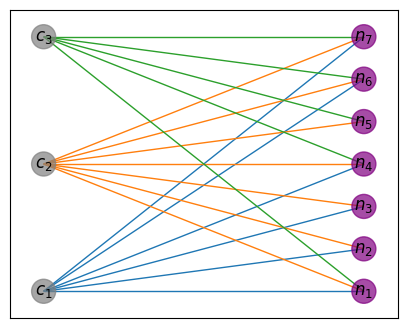

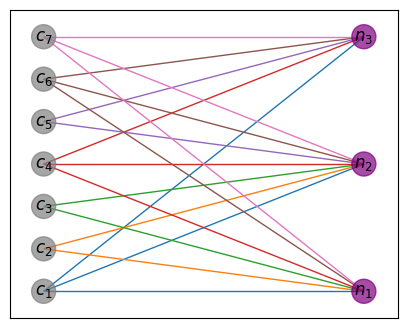

In [37]:
G = nx.Graph(env.state)

Gt = graph_transpose(G)

c, v = bpt.sets(G)
vt, ct = bpt.sets(Gt)

H1 = bpt.biadjacency_matrix(G, row_order=sorted(c), column_order=sorted(v), dtype=np.bool_)
H2 = bpt.biadjacency_matrix(Gt, row_order=sorted(vt), column_order=sorted(ct), dtype=np.bool_)

draw_bpt_graph(G)

draw_bpt_graph(graph_transpose(G))

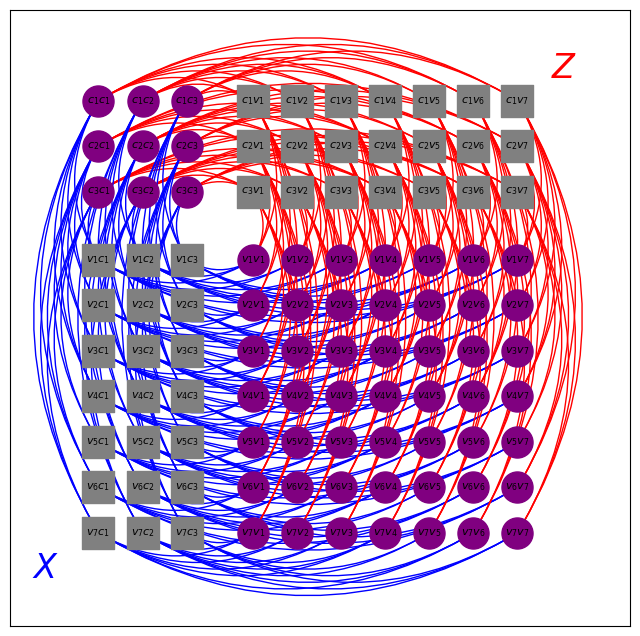

In [38]:
draw_hgp_graph(G)

In [84]:
G1, G2 = G, G
H1 = bpt.biadjacency_matrix(G1, row_order=sorted(c), column_order=sorted(v), dtype=np.bool_)
H2 = bpt.biadjacency_matrix(G2, row_order=sorted(c), column_order=sorted(v), dtype=np.bool_)
HGP = nx.cartesian_product(G1, G2)
m1, n1 = H1.shape
m2, n2 = H2.shape

Hx = sp.hstack([sp.kron(H1.T, sp.eye_array(m2)), # H1'x Im2
                sp.kron(sp.eye_array(n1), H2),   # In1 x H2'
               ], dtype=np.bool_) # [ H1'x Im2 | In1 x H2'] } n1*m2 rows
#                                    m1*m2 cols n1*n2 cols

Hz = sp.hstack([sp.kron(sp.eye_array(m1), H2.T), # Im1 x H2'
                sp.kron(H1, sp.eye_array(n2)),   # H1 x In2
               ], dtype=np.bool_) # [ Im1 x H2'| H1 x In2 ] } m1*n2 rows
#                                    m1*m2 cols n1*n2 cols

H = sp.vstack([Hz, Hx]).asformat('csc')

C, V = bpt.sets(HGP)
assert (H.todense() == bpt.biadjacency_matrix(HGP, row_order=sorted(V), 
                                              column_order=sorted(C)).todense()).all()

## Evaluating HGP codes in the erasure channel

In [85]:
import css_code_eval as css

codes = ['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]']
textfiles = ["../initial_codes/"+f"HGP_(3,4)_{code}.txt" for code in codes]

In [86]:
new_state = load_tanner_graph(textfiles[0])
num_trials = int(1e3)
p_vals = np.linspace(1e-1, 3e-1, 11)

results = css.MC_erasure_plog(num_trials, new_state, p_vals, rank_method=True)

In [87]:
results

{'mean': array([0.   , 0.   , 0.001, 0.   , 0.001, 0.001, 0.01 , 0.007, 0.017,
        0.03 , 0.037]),
 'std': array([0.        , 0.        , 0.03162278, 0.        , 0.03162278,
        0.03162278, 0.09954853, 0.08341438, 0.12933572, 0.17067258,
        0.18885621]),
 'rank_stats': array([0.999, 1.   , 0.999, 0.999, 0.999, 0.994, 0.983, 0.97 , 0.94 ,
        0.903, 0.872])}

In [5]:
# Rank based
print(f"Method: Rank based\n{num_trials = }, {p_vals.size = }")
%timeit results = css.MC_erasure_plog(num_trials, new_state, p_vals, rank_method=True)

# # Rank based
# print(f"Method: Rank based: only X\n{num_trials = }, {p_vals.size = }")
# %timeit results = css.MC_erasure_plog(num_trials, new_state, p_vals, rank_method=True, only_X=True)

# Exact or eta-gamma approach
print(f"Method: Eta-Gamma approach\n{num_trials = }, {p_vals.size = }")
%timeit results = css.MC_erasure_plog(num_trials, new_state, p_vals)

# # Exact or eta-gamma approach
# print(f"Method: Eta-Gamma approach: only X\n{num_trials = }, {p_vals.size = }")
# %timeit results = css.MC_erasure_plog(num_trials, new_state, p_vals, only_X=True)

Method: Rank based
num_trials = 1000, p_vals.size = 11
21.8 s ± 1.38 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Method: Rank based: only X
num_trials = 1000, p_vals.size = 11
14.6 s ± 1.56 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
Method: Eta-Gamma approach
num_trials = 1000, p_vals.size = 11
7.07 s ± 259 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Method: Eta-Gamma approach: only X
num_trials = 1000, p_vals.size = 11
3.36 s ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
new_state = load_tanner_graph(textfiles[0])
num_trials = int(1e4)
p_vals = np.linspace(1e-1, 3*1e-1, 11)

rank_based = css.MC_erasure_plog(num_trials, new_state, p_vals, rank_method=True)
# rank_based_X = css.MC_erasure_plog(num_trials, new_state, p_vals, rank_method=True, only_X=True)
eta_gamma = css.MC_erasure_plog(num_trials, new_state, p_vals)
# eta_gamma_X = css.MC_erasure_plog(num_trials, new_state, p_vals, only_X=True)

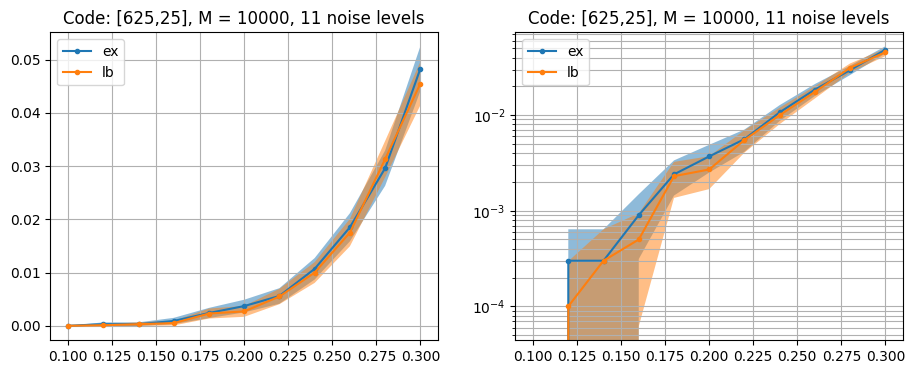

In [21]:
fig, (ax, axlog) = plt.subplots(1, 2, figsize=(11, 4))
ax.set_title(f'Code: {codes[0]}, M = {num_trials}, {len(p_vals)} noise levels')
for d, l in zip([eta_gamma, rank_based], 
                ['ex', 'lb']):
    ax.plot(p_vals, d['mean'], '.-', label=l)
    ax.fill_between(p_vals, 
                     d['mean'] - 1.96*d['std']/np.sqrt(num_trials), 
                     d['mean'] + 1.96*d['std']/np.sqrt(num_trials), 
                     alpha=0.5)
    
ax.legend()
ax.grid(which='both')

axlog.set_title(f'Code: {codes[0]}, M = {num_trials}, {len(p_vals)} noise levels')
for d, l in zip([eta_gamma, rank_based], 
                ['ex', 'lb']):
    axlog.semilogy(p_vals, d['mean'], '.-', label=l)
    axlog.fill_between(p_vals, 
                     d['mean'] - 1.96*d['std']/np.sqrt(num_trials), 
                     d['mean'] + 1.96*d['std']/np.sqrt(num_trials), 
                     alpha=0.5)
    
axlog.legend()
axlog.grid(which='both')

plt.show()

### What have we learned so far?
- The rank-based approach is supposed to be a lower bound to the eta-gamma approach, but so far I haven't found evidence of it being any lower. I.e., it's accurate enough.
- Surprisingly, the rank-based approach is SLOWER than the eta-gamma approach. This should be due to excessive overhead when converting to M4RI. We must refactor the whole Monte Carlo estimation directly in C to avoid this overhead.
- Actually, upon further consideration, it actually makes sense that rank-based is slower because the operations involved in both approaches are basically the same (echelonize some matrices), but in the rank-based approach, we always have to compute the rank of a relatively large matrix, $H_{\bar{\mathcal{E}}}$, whereas in the eta-gamma approach, only the $H_{\mathcal{E}}$ matrix is exploited at each iteration.
- About the C refactoring, did that, and at first, much to my horror, the Python version for the eta-gamma approach was actually faster. I managed to rework the C version to make it faster, but so far it is only slightly faster than the Python version. For the rank-based method, it sped up by a factor of about 5, but it's still slower than eta-gamma. 
- The relation between P(x_logical_error) and P(x_logical_error or z_logical_error) is not as simple as I thought. X and Z logical errors do not seem to be independent nor simultaneous, but correlated with some nontrivial positive correlation. However, for optimization purposes, computing only the x logical error rate should be fine, as the relation between those two quantities is still supposed to be monotonic.
- As expected, the X_only variations are roughly twice as fast as their X|Z counterparts. 
- As logic mandates, the symplectic variant of the rank based approach is indeed slower and the little advantage it had was for very small codes only.
- Takeaway numbers: ~$8$s for $10^4$ MC trials per value of $p$, by using the eta-gamma X|Z approach. (Python implementation).
- Takeaway numbers: ~$6.5$s for $10^4$ MC trials per value of $p$, by using the eta-gamma X|Z approach. (C implementation).
- Note: these numbers depend a lot on the particular noise levels. In general, the time is grows with the noise level, and so does the advantage of the C implementation vs. the Python one. 

## Testing on larger codes

In [8]:
# draw_bpt_graph(new_state)
# draw_hgp_graph(new_state, fontsize=0, nodesize=50)

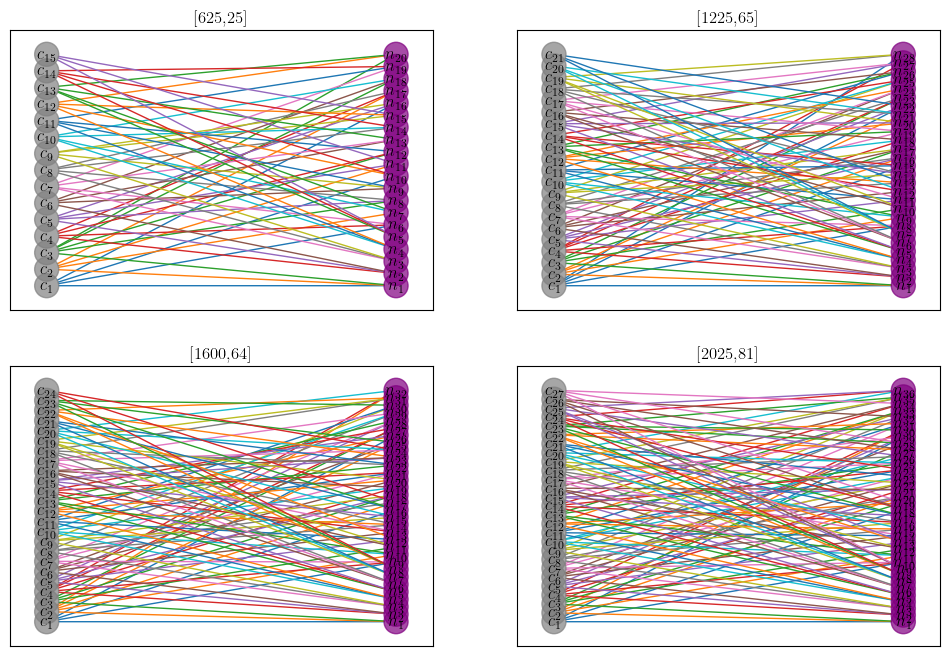

In [53]:
states = {txt: load_tanner_graph(txt) for txt in textfiles}

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
for lbl, txt, ax in zip(codes, states, axs.flatten()):
    ax.set_title(lbl)
    draw_bpt_graph(states[txt], ax)

plt.show()


# fig, axs = plt.subplots(2, 2, figsize=(12, 8))
# for lbl, txt, ax in zip(codes, states, axs.flatten()):
#     ax.set_title(lbl)
#     draw_hgp_graph(states[txt], fontsize=0, nodesize=10, ax=ax)

# plt.show()

In [81]:
from pym4ri import rank

def HGP_symp(H1: sp.csr_array, H2: sp.csr_array=None):
    # Convention: H1 is the vertical axis, H2 is the horizontal axis
    # BB | BC (Z stab)
    # CB | CC
    # (X stab)
    if H2 is None:
        H2 = H1
    H1 = H1.astype(np.uint)
    H2 = H2.astype(np.uint)
    (m1, n1), (m2, n2) = H1.shape, H2.shape
    I = lambda n: sp.eye_array(n, dtype=np.uint)
    Hz = sp.hstack([sp.kron(I(n1), H2), sp.kron(H1.T, I(m2))]).asformat('csr')
    Hx = sp.hstack([sp.kron(H1, I(n2)), sp.kron(I(m1), H2.T)]).asformat('csr')
    return Hx, Hz

In [136]:
H = bpt.biadjacency_matrix(states[textfiles[1]], row_order=np.arange(21), column_order=np.arange(21, 21+28))
H = H.todense()
rank(H.astype(bool))



# Hx, Hz = HGP_symp(H)
# 1600 - (rank(Hx.todense().astype(bool)) + rank(Hz.todense().astype(bool)))

# for r in H:
#     print(''.join([str(b) for b in r]))
        

20

In [102]:
H = bpt.biadjacency_matrix(from_edgelist(best_from_sadl_data[codes[2]]['beta=10']['theta']), 
                           row_order=np.arange(24), column_order=np.arange(24, 24+32))

# rank(H.todense().astype(bool))

Hx, Hz = HGP_symp(H)
1600 - (rank(Hx.todense().astype(bool)) + rank(Hz.todense().astype(bool)))


64

In [6]:
report, stats = {name: {} for name in codes}, {name: {} for name in codes}

num_trials = int(1e4)
p_vals = np.linspace(1e-1, 5e-1, 17)

report['p_vals'] = p_vals
report['M'] = num_trials

# Run experiments - takes a loooooong time
for name, state in zip(codes, states.values()):
    
    report[name]['ex'] = %timeit -o css.MC_erasure_plog(num_trials, state, p_vals)
    report[name]['lb'] = %timeit -o css.MC_erasure_plog(num_trials, state, p_vals, rank_method=True)
    
    stats[name]['ex'] = css.MC_erasure_plog(num_trials, state, p_vals)
    stats[name]['lb'] = css.MC_erasure_plog(num_trials, state, p_vals, rank_method=True)


2min 20s ± 805 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
5min 35s ± 6.02 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
8min 18s ± 2.25 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
23min 56s ± 5.94 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
14min 29s ± 2.13 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
37min 32s ± 35.1 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
24min 10s ± 4.33 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
1h 47s ± 17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
times = {name: {} for name in codes}
for name in codes:
    for mode in ['ex', 'lb']: #
        t = np.array(report[name][mode].timings)
        times[name][mode] = {'mean': t.mean(), 'std': t.std()}


In [8]:
# Save report, times, stats
import pickle

with open('simulations_C_1e4.pkl', 'wb') as file:
    data = [report, times, stats]
    pickle.dump(data, file)

# with open('simulations.pkl', 'rb') as file:
#     report, times, stats = pickle.load(file)

In [9]:
for name in codes:
    print(f"Code: {name}")
    print(f"M = {report['M']}")
    print(f"p_s = {report['p_vals']}")
    print(f" eta-gamma runtime: {report[name]['ex'].__str__().split('per loop')[0]}")
    print(f"rank based runtime: {report[name]['lb'].__str__().split('per loop')[0]}")
    print()
    

Code: [625,25]
M = 10000
p_s = [0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325 0.35  0.375
 0.4   0.425 0.45  0.475 0.5  ]
 eta-gamma runtime: 2min 20s ± 805 ms 
rank based runtime: 5min 35s ± 6.02 s 

Code: [1225,65]
M = 10000
p_s = [0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325 0.35  0.375
 0.4   0.425 0.45  0.475 0.5  ]
 eta-gamma runtime: 8min 18s ± 2.25 s 
rank based runtime: 23min 56s ± 5.94 s 

Code: [1600,64]
M = 10000
p_s = [0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325 0.35  0.375
 0.4   0.425 0.45  0.475 0.5  ]
 eta-gamma runtime: 14min 29s ± 2.13 s 
rank based runtime: 37min 32s ± 35.1 s 

Code: [2025,81]
M = 10000
p_s = [0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275 0.3   0.325 0.35  0.375
 0.4   0.425 0.45  0.475 0.5  ]
 eta-gamma runtime: 24min 10s ± 4.33 s 
rank based runtime: 1h 47s ± 17 s 



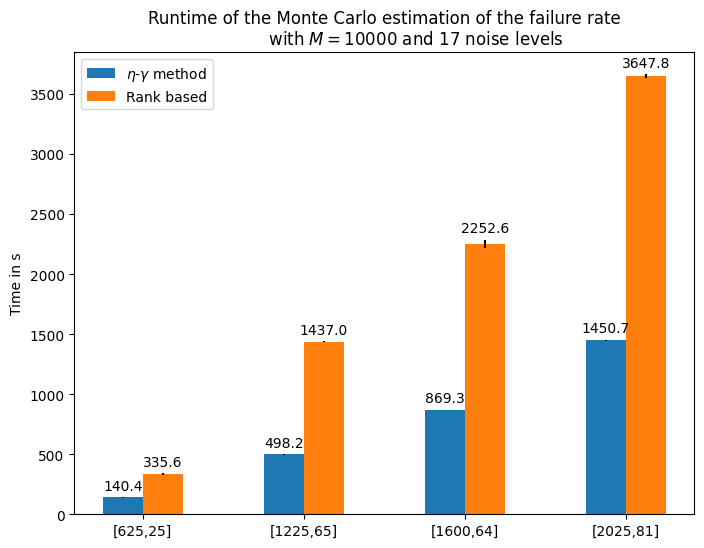

In [12]:
methods = {'ex': r'$\eta$-$\gamma$ method', 'lb': r'Rank based'}

plt.figure(figsize=(8,6))
plt.title(f'''Runtime of the Monte Carlo estimation of the failure rate
            with $M = {num_trials}$ and {p_vals.size} noise levels''')

width = 0.25
for i, mode in enumerate(['ex', 'lb']):
    means = [times[name][mode]['mean'] for name in codes]
    stds = [times[name][mode]['std'] for name in codes]
    
    bars = plt.bar(np.arange(len(codes)) + width*(i-.5), means, width, 
                   yerr=stds, label=methods[mode], align='center')
    plt.bar_label(bars, padding=3, fmt=lambda x: f'{x:.1f}')
    

plt.ylabel('Time in s')
plt.xticks(np.arange(len(codes)), labels=codes)
plt.legend()

plt.show()

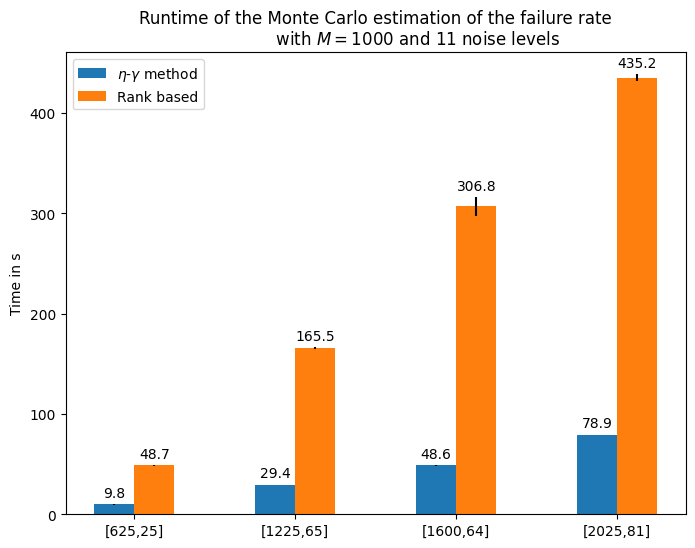

In [24]:
# DON'T TOUCH THIS!!!!!!!!!

# methods = {'ex': r'$\eta$-$\gamma$ method', 'lb': r'Rank based'}

# plt.figure(figsize=(8,6))
# plt.title(f'''Runtime of the Monte Carlo estimation of the failure rate
#                 with $M = {num_trials}$ and {p_vals.size} noise levels''')

# width = 0.25
# for i, mode in enumerate(['ex', 'lb']):
#     means = [times[name][mode]['mean'] for name in codes]
#     stds = [times[name][mode]['std'] for name in codes]
    
#     bars = plt.bar(np.arange(len(codes)) + width*(i-.5), means, width, 
#                    yerr=stds, label=methods[mode], align='center')
#     plt.bar_label(bars, padding=3, fmt=lambda x: f'{x:.1f}')
    

# plt.ylabel('Time in s')
# plt.xticks(np.arange(len(codes)), labels=codes)
# plt.legend()

# plt.show()

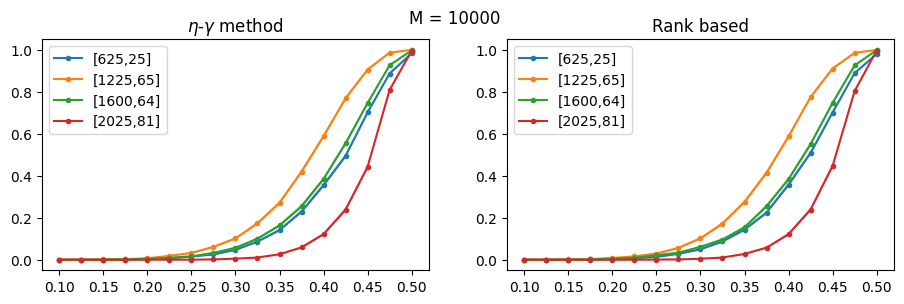

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(11,3))
plt.suptitle(f'M = {num_trials}')

for mode, ax in zip(['ex', 'lb'], axs):
    ax.set_title(methods[mode])
    means = np.vstack([stats[name][mode]['mean'] for name in codes])
    stds = np.vstack([stats[name][mode]['std'] for name in codes])
    
    for m, s, name in zip(means, stds, codes):
        ax.plot(p_vals, m, '.-', label=name)
        ax.fill_between(p_vals, m - 1.96*s/np.sqrt(num_trials), 
                         m + 1.96*s/np.sqrt(num_trials), alpha=0.5)
    
    ax.legend()

plt.show()

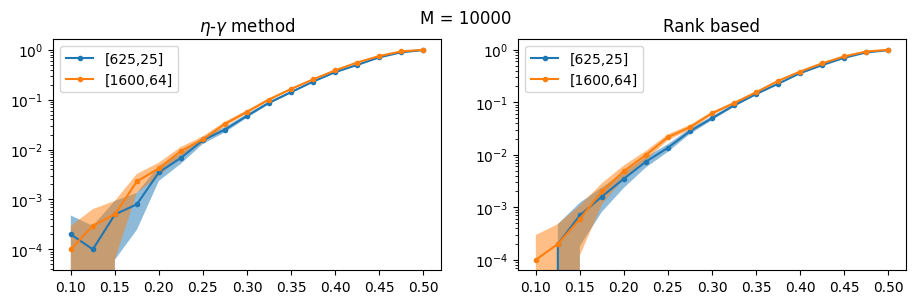

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(11,3))
plt.suptitle(f'M = {num_trials}')

for mode, ax in zip(['ex', 'lb'], axs):
    ax.set_title(methods[mode])
    means = np.vstack([stats[name][mode]['mean'] for name in codes[::2]])
    stds = np.vstack([stats[name][mode]['std'] for name in codes[::2]])
    
    for m, s, name in zip(means, stds, codes[::2]):
        ax.semilogy(p_vals, m, '.-', label=name)
        ax.fill_between(p_vals, m - 1.96*s/np.sqrt(num_trials), 
                         m + 1.96*s/np.sqrt(num_trials), alpha=0.5)
    
    ax.legend()

plt.show()

In [52]:
res_0 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[0]], p_vals=[9/32])
res_1 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[1]], p_vals=[8/32])
res_2 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[2]], p_vals=[9/32])
res_3 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[3]], p_vals=[12/32])

In [54]:
%timeit res_0 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[0]], p_vals=[9/32])
%timeit res_1 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[1]], p_vals=[8/32])
%timeit res_2 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[2]], p_vals=[9/32])
%timeit res_3 = css.MC_erasure_plog(num_trials=int(1e4), state=states[textfiles[3]], p_vals=[12/32])

8.51 s ± 58.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
27 s ± 633 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
49.3 s ± 354 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1min 53s ± 1.02 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
for res in [res_0, res_1, res_2, res_3]:
    m, s = res['mean'][0], res['std'][0]/np.sqrt(num_trials)
    print(f"{m:.3g} +- {s:.3g} | {s/m:.3g}")

0.0308 +- 0.00173 | 0.0561
0.0329 +- 0.00178 | 0.0542
0.0413 +- 0.00199 | 0.0482
0.0576 +- 0.00233 | 0.0405


# Simulated Annealing

In [4]:
from css_code_eval import *
from simulated_annealing import *
from experiments_settings import *
import h5py

sa_data = {}

with h5py.File('sim_ann.hdf5', 'r') as f:
    for code, grp in f.items():
        sa_data[code] = {}
        for beta, subgrp in grp.items():
            sa_data[code][beta] = {}
            sa_data[code][beta]['theta'] = subgrp['theta'][()].copy()
            sa_data[code][beta]['cost'] = subgrp['cost'][()].copy()
            sa_data[code][beta]['std'] = subgrp['std'][()].copy()
            sa_data[code][beta]['delta'] = subgrp['delta'][()].copy()
            sa_data[code][beta]['temp'] = subgrp['temp'][()].copy()




In [5]:
import pandas as pd

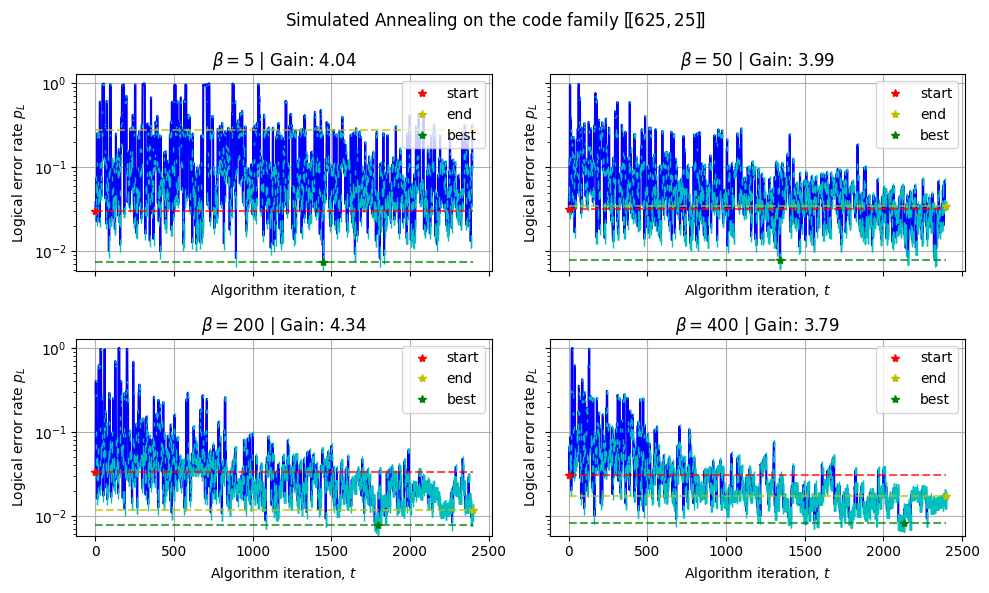

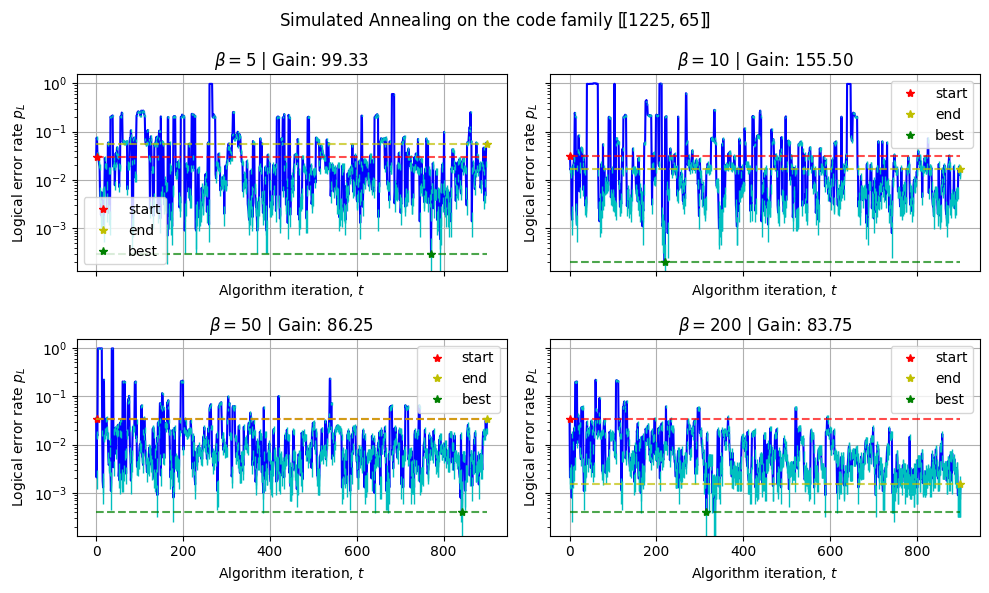

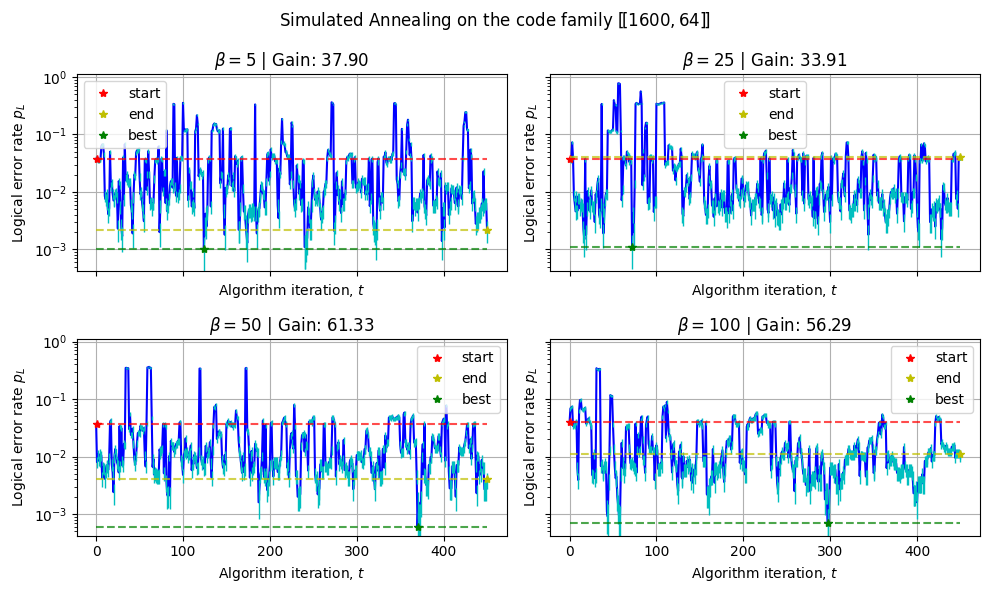

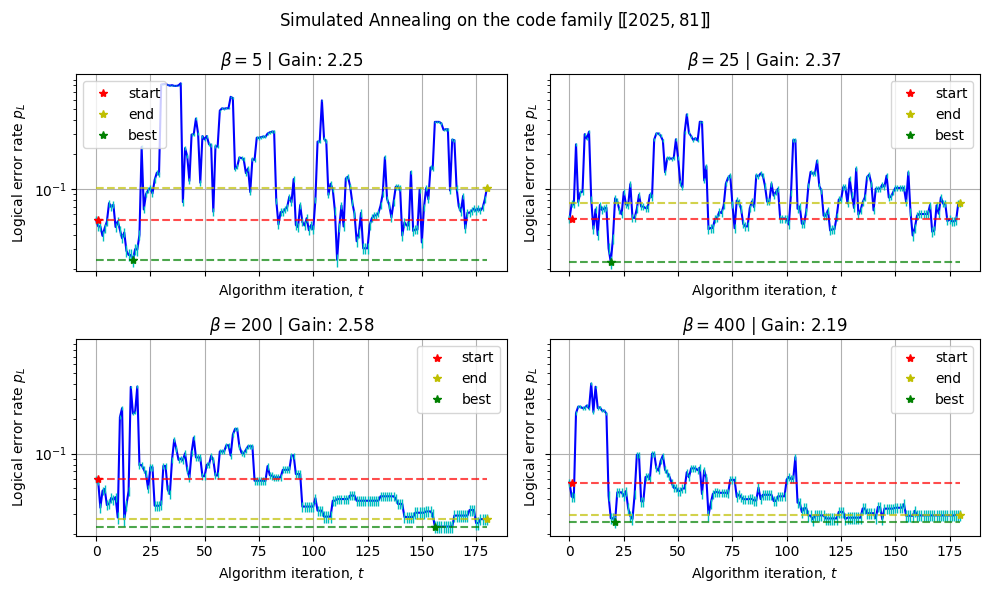

In [6]:
betas = {codes[0]: [5, 50, 200, 400], 
         codes[1]: [5, 10, 50, 200], 
         codes[2]: [5, 25, 50, 100], 
         codes[3]: [5, 25, 200, 400], 
        }
    
for i, (code, maxiter) in enumerate(zip(codes, sim_ann_params['max_iter'])):
    t = maxiter
    fig, ((ax0, ax1), 
          (ax2, ax3),) = plt.subplots(2, 2, figsize=(10,6), sharex=True, sharey=True)
    plt.suptitle(r"Simulated Annealing on the code family $[\!{{{}}}\!]$".format(code))
    
    
    for beta, ax in zip(betas[code], [ax0, ax1, ax2, ax3]):
        cost = sa_data[code][f'beta={beta}']['cost'].flatten()
        std = sa_data[code][f'beta={beta}']['std'].flatten()
        gain = cost[0]/cost.min()
        ax.set_title(r"$\beta = "+f"{beta}$ | Gain: {gain:.2f}")
        ax.semilogy(np.arange(t+1), cost, 'b')
        # filtered_cost = pd.DataFrame(cost).rolling(window=len(cost)//50).mean()
        # ax.semilogy(np.arange(t+1), filtered_cost, 'm')
        ax.vlines(x=np.arange(t+1), ymin=cost-1.96*std/np.sqrt(1e4), 
                  ymax=cost+1.96*std/np.sqrt(1e4), color='c', linewidth=1)
        ax.hlines(y=cost[0], xmin=0, xmax=t, color='r', linestyle='--', alpha=0.7)
        ax.semilogy(1, cost[0], 'r*', label='start')
        ax.hlines(y=cost[-1], xmin=0, xmax=t, color='y', linestyle='--', alpha=0.7)
        ax.semilogy(t, cost[-1], 'y*', label='end')
        ax.hlines(y=cost.min(), xmin=0, xmax=t, color='g', linestyle='--', alpha=0.7)
        ax.semilogy(cost.argmin(), cost.min(), 'g*', label='best')
        ax.set_ylabel('Logical error rate $p_L$')
        ax.set_xlabel('Algorithm iteration, $t$')
        ax.grid('minor')
        ax.legend()

    plt.tight_layout()

    # plt.savefig(f'../img/SAbase{i}.pdf')
    
    plt.show()

In [7]:
# for code, maxiter in zip(codes, sim_ann_params['max_iter']):
#     t = maxiter
#     fig, ((ax0, ax1), 
#           (ax2, ax3), 
#           (ax4, ax5), 
#           (ax6, _)) = plt.subplots(4, 2, figsize=(10,18), sharex=True, sharey=True)
#     plt.suptitle(f"Simulated Annealing on the code family {code}\n")
#     plt.tight_layout()
    
#     for beta, ax in zip(sim_ann_params['beta'], [ax0, ax1, ax2, ax3, ax4, ax5, ax6]):
#         delta = sa_data[code][f'beta={beta}']['delta'].flatten()
#         temp = sa_data[code][f'beta={beta}']['temp'].flatten()
#         prob = np.minimum(1, np.exp(-delta/temp))
#         ax.set_title(r"$\beta = "+f"{beta}$")
#         ax.plot(np.arange(t)[::10], delta[::10], 'y')
#         ax.plot(np.arange(t)[::10], temp[::10], 'r')
#         ax.plot(np.arange(t)[::10], prob[::10], 'b')
    
#     plt.show()

## Performance of optimized codes in different noise level regimes

Now, let us investigate whether the optimal codes found during the simulated annealing outperform the original codes for other noise levels as well. 

In [7]:
# with h5py.File("best_from_sa.hdf5", "a") as f: 
#         for code, noise_lvl, txtfile in zip(codes, noise_levels, textfiles):
#             grp = f.require_group(code)
#             grp.attrs['p'] = noise_lvl
#             for beta in [5, 10, 25, 50, 100, 200, 400]:
#                 subgrp = grp.require_group(f'{beta=:.0f}')
#                 dset = sa_data[code][f'{beta=:.0f}']
#                 theta, _ = min( ( (th, c) for th, c in zip(dset['theta'], dset['cost']) ), 
#                                 key=lambda pair: pair[1])
#                 subgrp.create_dataset("theta", data=theta)

#             subgrp = grp.require_group('initial')
#             subgrp.create_dataset('theta', 
#                                   data=parse_edgelist(load_tanner_graph(path_to_initial_codes+txtfile)))

In [8]:
best = {code: {} for code in codes}

for code in codes:
    for beta, dset in sa_data[code].items():
        best[code][beta], _ = min(((from_edgelist(th), c) for th, c in zip(dset['theta'], dset['cost'])), 
                                key=lambda pair: pair[1])


In [38]:
# best
# set(load_tanner_graph(path_to_initial_codes+textfiles[0]).edges(data=False)).__len__(), \
# set(best[codes[0]]['beta=200'].edges(data=False)).__len__()

In [9]:
best_from_sa_data = {}

with h5py.File('best_from_sa.hdf5', 'r') as f:
    for code, grp in f.items():
        best_from_sa_data[code] = {}
        for beta, subgrp in grp.items():
            best_from_sa_data[code][beta] = {}
            best_from_sa_data[code][beta]['theta'] = subgrp['theta'][()].copy()
            best_from_sa_data[code][beta]['mean'] = subgrp['mean'][()].copy()
            best_from_sa_data[code][beta]['std'] = subgrp['std'][()].copy()


In [10]:
best_from_sa_data.keys(), \
best_from_sa_data[codes[0]].keys(), \
best_from_sa_data[codes[0]]['initial'].keys()

(dict_keys(['[1225,65]', '[1600,64]', '[2025,81]', '[625,25]']),
 dict_keys(['beta=10', 'beta=100', 'beta=200', 'beta=25', 'beta=400', 'beta=5', 'beta=50', 'initial']),
 dict_keys(['theta', 'mean', 'std']))

In [11]:
from analyze_best_from_sa import MC_budget, p_vals

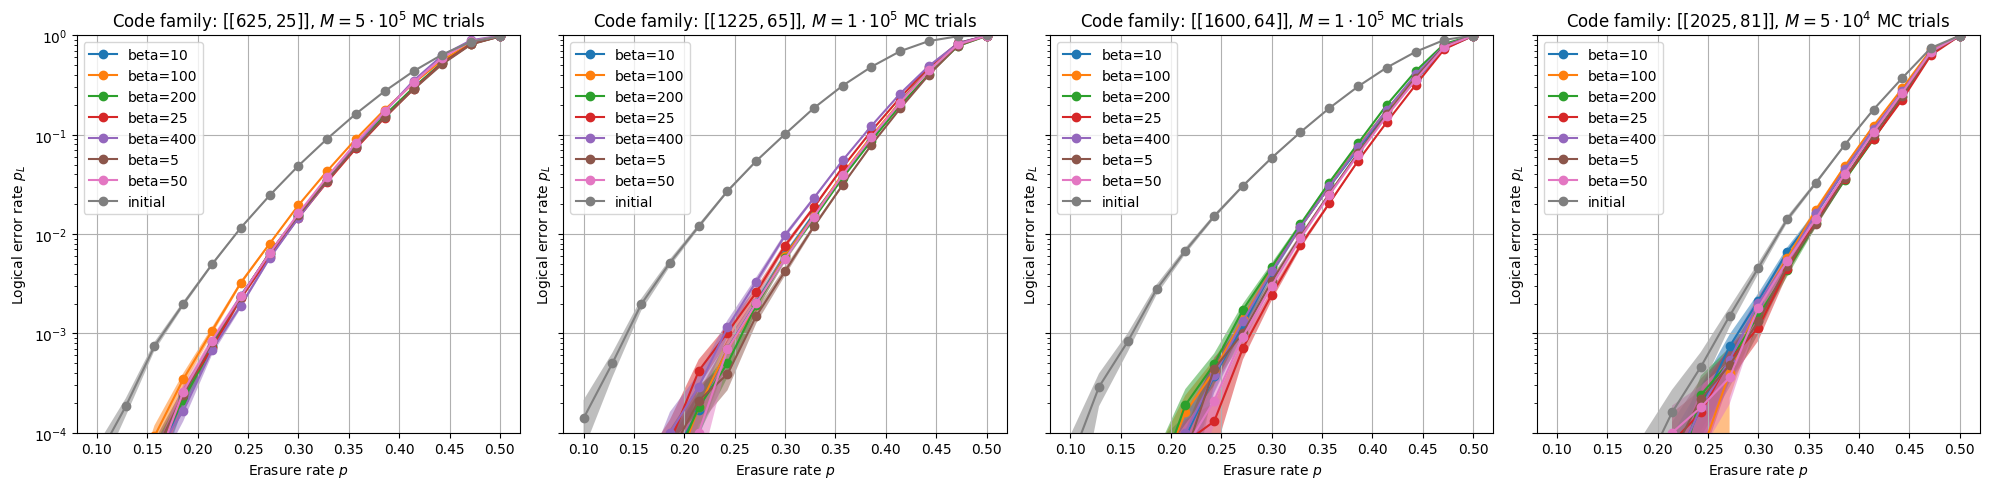

In [12]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20,5), sharex=True, sharey=True)

for code, ax, M in zip(codes, [ax0, ax1, ax2, ax3], MC_budget):
    Morder = np.floor(np.log10(M)).astype(int)
    Mantissa = M//10**Morder
    ax.set_title(f'Code family: $[{code}]$, $M = {Mantissa}\\cdot10^{{{Morder}}}$ MC trials')
    data = best_from_sa_data[code]
    for k, d in data.items():
        # if k == 'initial':
        #     ax.semilogy(p_vals, d['mean'], 'o-')
        #     ax.fill_between(p_vals, d['mean'] - 1.96*d['std']/np.sqrt(M), 
        #                     d['mean'] + 1.96*d['std']/np.sqrt(M), alpha=0.5)
        ax.semilogy(p_vals, d['mean'], 'o-', label=k)
        ax.fill_between(p_vals, d['mean'] - 1.96*d['std']/np.sqrt(M), 
                        d['mean'] + 1.96*d['std']/np.sqrt(M), alpha=0.5)
    ax.legend()
    ax.set_ylim([1e-4, 1e-0])
    ax.set_xlabel('Erasure rate $p$')
    ax.set_ylabel('Logical error rate $p_L$')
    ax.grid('minor')

plt.tight_layout()

# plt.savefig('../img/SAbasecodesperf.pdf')

plt.show()

# fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

# for code, ax, M in zip(codes, [ax0, ax1, ax2, ax3], MC_budget):
#     Morder = np.floor(np.log10(M)).astype(int)
#     Mantissa = M//10**Morder
#     ax.set_title(f'Code family: $[{code}]$, $M = {Mantissa}\\cdot10^{{{Morder}}}$ MC trials')
#     data = best_from_sa_data[code]
#     for k, d in data.items():
#         # if k == 'initial':
#         #     ax.semilogy(p_vals, d['mean'], 'o-')
#         #     ax.fill_between(p_vals, d['mean'] - 1.96*d['std']/np.sqrt(M), 
#         #                     d['mean'] + 1.96*d['std']/np.sqrt(M), alpha=0.5)
#         ax.semilogy(p_vals, d['mean'], 'o-', label=k)
#         ax.fill_between(p_vals, d['mean'] - 1.96*d['std']/np.sqrt(M), 
#                         d['mean'] + 1.96*d['std']/np.sqrt(M), alpha=0.5)
#     ax.legend()
#     ax.set_ylim([1e-4, 1e-0])
#     ax.set_xlabel('Erasure rate $p$')
#     ax.set_ylabel('Logical error rate $p_L$')
#     ax.grid('minor')

# plt.tight_layout()

# plt.savefig('../img/SAbasecodesperf_slides.pdf')

# plt.show()

## Trying a different temperature scheduling scheme

The current temperature scheduling scheme is of the form $T(t) = \frac{1}{1 + \beta \cdot t^2}$, for $0 \le t \le 1$ representing the progress of the simulation. Based on a temperature function $T(t)$, the probability of accepting a worse state is based on the cost difference $\Delta C$, given by $\exp(-\Delta C / T(t))$. 

Since the cost function is restricted to a short range ($[0, 1]$), and the variation is relatively low, the behavior of the cost function is better visualized in log-scale, so it may be better to employ the difference in the log-cost to build the acceptation probability, as in $\exp(-\Delta \log C / T(t))$. 

In [13]:
from css_code_eval import *
from simulated_annealing import *
from experiments_settings import *
import h5py

sadl_data = {}

with h5py.File('sim_ann_deltalog.hdf5', 'r') as f:
    for code, grp in f.items():
        sadl_data[code] = {}
        for beta, subgrp in grp.items():
            sadl_data[code][beta] = {}
            sadl_data[code][beta]['theta'] = subgrp['theta'][()].copy()
            sadl_data[code][beta]['cost'] = subgrp['cost'][()].copy()
            sadl_data[code][beta]['std'] = subgrp['std'][()].copy()
            sadl_data[code][beta]['delta'] = subgrp['delta'][()].copy()
            sadl_data[code][beta]['temp'] = subgrp['temp'][()].copy()


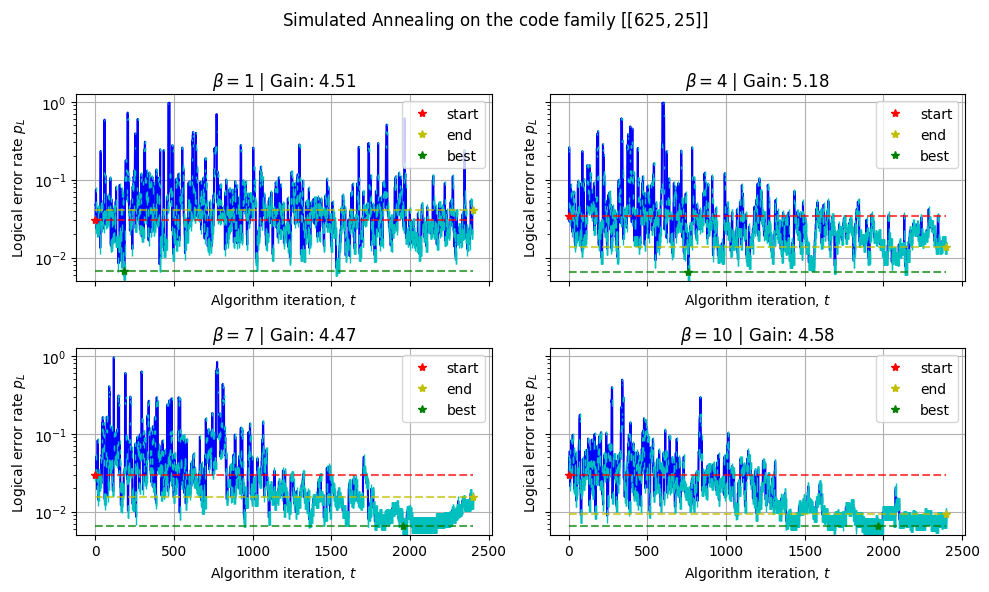

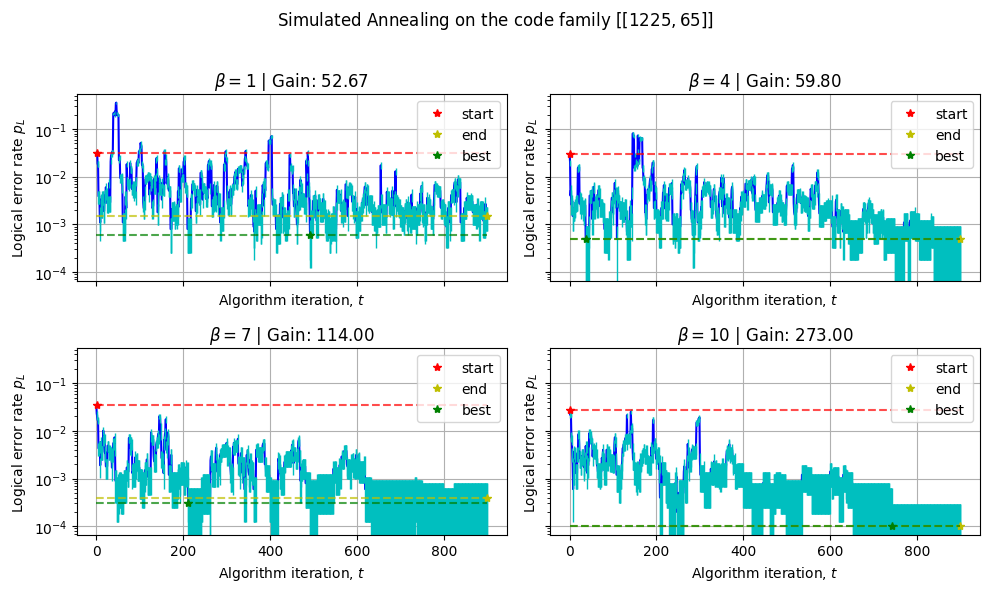

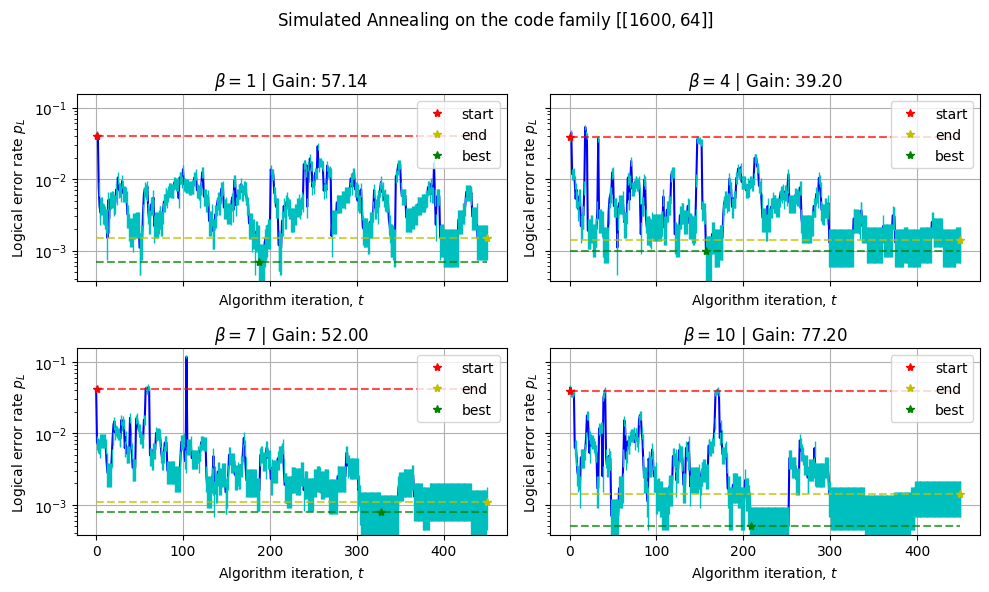

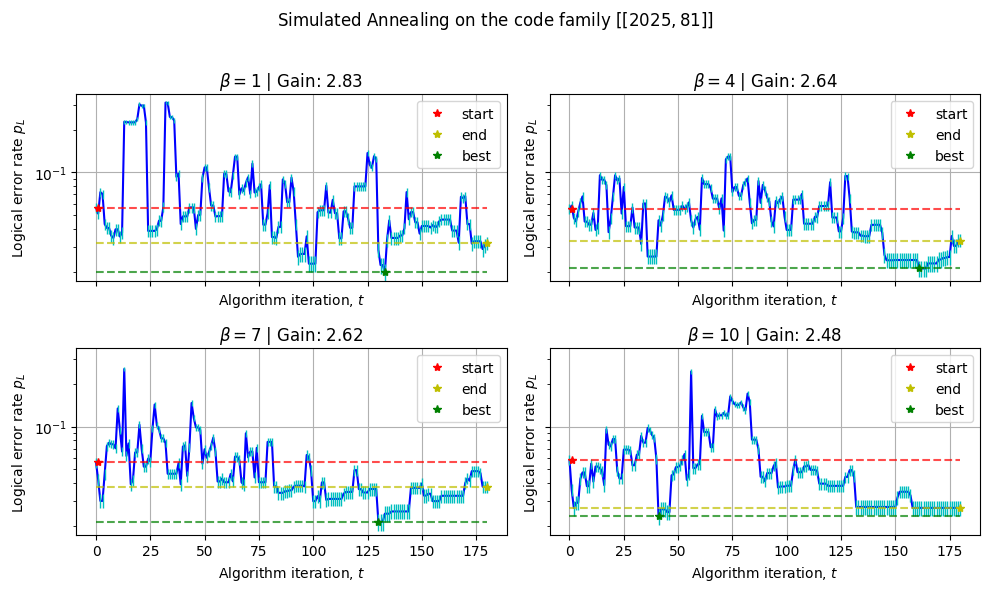

In [15]:
for i, (code, maxiter) in enumerate(zip(codes, sim_ann_params['max_iter'])):
    t = maxiter
    fig, ((ax0, ax1), 
          (ax2, ax3),) = plt.subplots(2, 2, figsize=(10,6), sharex=True, sharey=True)
    plt.suptitle(f"Simulated Annealing on the code family $[{code}]$\n")
    
    
    for beta, ax in zip(sim_ann_params['betadl'], [ax0, ax1, ax2, ax3]):
        cost = sadl_data[code][f'beta={beta}']['cost'].flatten()
        std = sadl_data[code][f'beta={beta}']['std'].flatten()
        gain = cost[0]/cost.min()
        ax.set_title(r"$\beta = "+f"{beta}$ | Gain: {gain:.2f}")
        ax.semilogy(np.arange(t+1), cost, 'b')
        # filtered_cost = pd.DataFrame(cost).rolling(window=len(cost)//50).mean()
        # ax.semilogy(np.arange(t+1), filtered_cost, 'm')
        ax.vlines(x=np.arange(t+1), ymin=cost-1.96*std/np.sqrt(1e4), 
                  ymax=cost+1.96*std/np.sqrt(1e4), color='c', linewidth=1)
        ax.hlines(y=cost[0], xmin=0, xmax=t, color='r', linestyle='--', alpha=0.7)
        ax.semilogy(1, cost[0], 'r*', label='start')
        ax.hlines(y=cost[-1], xmin=0, xmax=t, color='y', linestyle='--', alpha=0.7)
        ax.semilogy(t, cost[-1], 'y*', label='end')
        ax.hlines(y=cost.min(), xmin=0, xmax=t, color='g', linestyle='--', alpha=0.7)
        ax.semilogy(cost.argmin(), cost.min(), 'g*', label='best')
        ax.set_ylabel('Logical error rate $p_L$')
        ax.set_xlabel('Algorithm iteration, $t$')
        ax.grid('minor')
        ax.legend()

    plt.tight_layout()

    # plt.savefig(f'../img/SAdl{i}.pdf')
    
    plt.show()

In [10]:
# RUN ONCE TO CREATE FILE

# with h5py.File("best_from_sadl.hdf5", "a") as f: 
#         for code, noise_lvl, txtfile in zip(codes, noise_levels, textfiles):
#             grp = f.require_group(code)
#             grp.attrs['p'] = noise_lvl
#             for beta in [1, 4, 7, 10]:
#                 subgrp = grp.require_group(f'{beta=:.0f}')
#                 dset = sadl_data[code][f'{beta=:.0f}']
#                 theta, _ = min( ( (th, c) for th, c in zip(dset['theta'], dset['cost']) ), 
#                                 key=lambda pair: pair[1])
#                 subgrp.create_dataset("theta", data=theta)

#             subgrp = grp.require_group('initial')
#             subgrp.create_dataset('theta', 
#                                   data=parse_edgelist(load_tanner_graph(path_to_initial_codes+txtfile)))

In [17]:
# After running batch job, fetch results from server and run this

best_from_sadl_data = {}

with h5py.File('best_from_sadl.hdf5', 'r') as f:
    for code, grp in f.items():
        best_from_sadl_data[code] = {}
        for beta, subgrp in grp.items():
            best_from_sadl_data[code][beta] = {}
            best_from_sadl_data[code][beta]['theta'] = subgrp['theta'][()].copy()
            best_from_sadl_data[code][beta]['mean'] = subgrp['mean'][()].copy()
            best_from_sadl_data[code][beta]['std'] = subgrp['std'][()].copy()


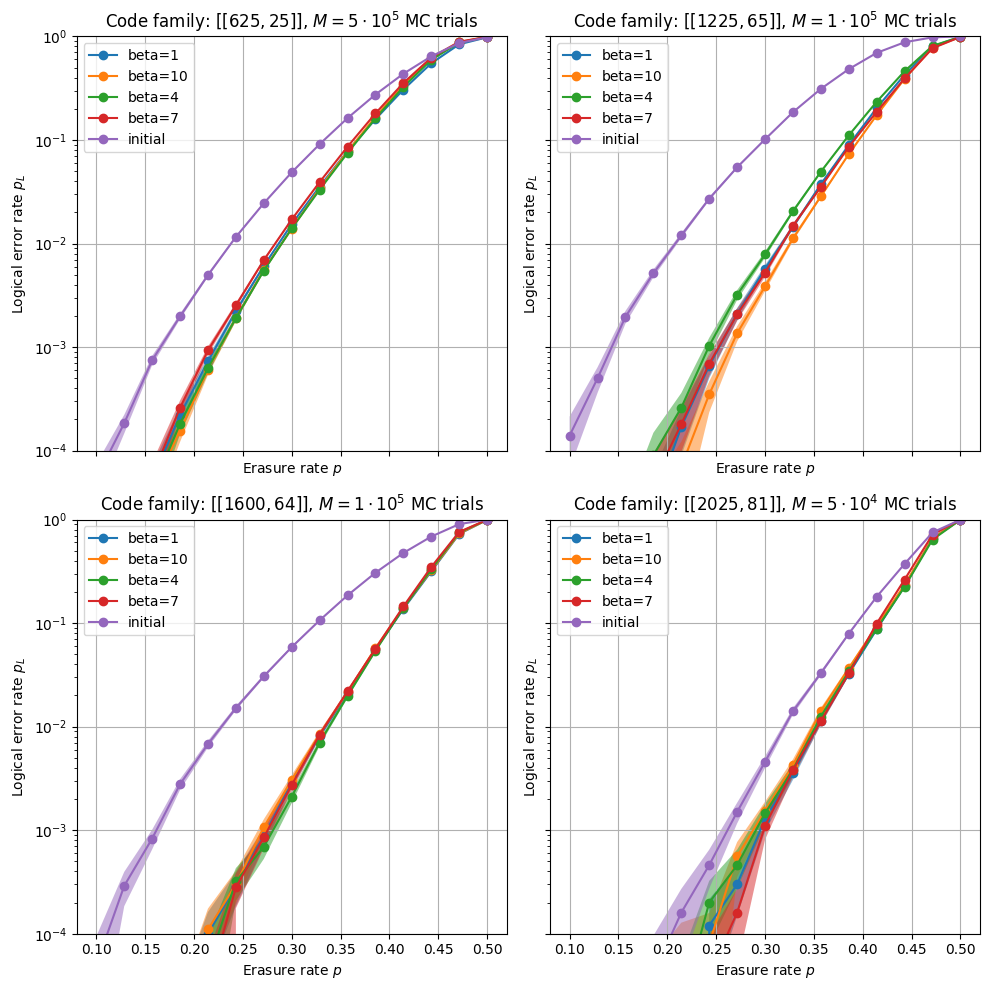

In [18]:
# from analyze_best_from_sa import MC_budget, p_vals

# fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20,5), sharex=True, sharey=True)

# for code, ax, M in zip(codes, [ax0, ax1, ax2, ax3], MC_budget):
#     Morder = np.floor(np.log10(M)).astype(int)
#     Mantissa = M//10**Morder
#     ax.set_title(f'Code family: $[{code}]$, $M = {Mantissa}\\cdot10^{{{Morder}}}$ MC trials')
#     data = best_from_sadl_data[code]
#     for k, d in data.items():
#         # if k == 'initial':
#         #     ax.semilogy(p_vals, d['mean'], 'o-')
#         #     ax.fill_between(p_vals, d['mean'] - 1.96*d['std']/np.sqrt(M), 
#         #                     d['mean'] + 1.96*d['std']/np.sqrt(M), alpha=0.5)
#         ax.semilogy(p_vals, d['mean'], 'o-', label=k)
#         ax.fill_between(p_vals, d['mean'] - 1.96*d['std']/np.sqrt(M), 
#                         d['mean'] + 1.96*d['std']/np.sqrt(M), alpha=0.5)
#     ax.legend()
#     ax.set_ylim([1e-4, 1e-0])
#     ax.set_xlabel('Erasure rate $p$')
#     ax.set_ylabel('Logical error rate $p_L$')
#     ax.grid('minor')

# plt.tight_layout()

# plt.savefig('../img/SAdlcodesperf.pdf')

# plt.show()

from analyze_best_from_sa import MC_budget, p_vals

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for code, ax, M in zip(codes, [ax0, ax1, ax2, ax3], MC_budget):
    Morder = np.floor(np.log10(M)).astype(int)
    Mantissa = M//10**Morder
    ax.set_title(f'Code family: $[{code}]$, $M = {Mantissa}\\cdot10^{{{Morder}}}$ MC trials')
    data = best_from_sadl_data[code]
    for k, d in data.items():
        # if k == 'initial':
        #     ax.semilogy(p_vals, d['mean'], 'o-')
        #     ax.fill_between(p_vals, d['mean'] - 1.96*d['std']/np.sqrt(M), 
        #                     d['mean'] + 1.96*d['std']/np.sqrt(M), alpha=0.5)
        ax.semilogy(p_vals, d['mean'], 'o-', label=k)
        ax.fill_between(p_vals, d['mean'] - 1.96*d['std']/np.sqrt(M), 
                        d['mean'] + 1.96*d['std']/np.sqrt(M), alpha=0.5)
    ax.legend()
    ax.set_ylim([1e-4, 1e-0])
    ax.set_xlabel('Erasure rate $p$')
    ax.set_ylabel('Logical error rate $p_L$')
    ax.grid('minor')

plt.tight_layout()

# plt.savefig('../img/SAdlcodesperf_slides.pdf')

plt.show()

## Exploring the cost function across the state space

In order to understand how to choose the Monte Carlo budget, the physical noise level, and, in a second moment, how to properly tune the Simulated Annealing algorithm as well as the several parameters in the Projective Simulation framework, we need to understand how the cost function (i.e., the estimated logical error rate for the erasure channel) varies across a sample of the state space. 

We'll do so by exploring the space at random, i.e., doing a random walk along the states, and evaluating the states along the path, as well as a small part of its neighborhood, to understand how the function varies between neighboring states. 

This is important to give us a hint on whether the pre-defined Monte Carlo budget is enough to correctly compare the quality of two distinct (especially neighboring) states. In other words, we need to check that the variation of the function across different states is of a higher order of magnitude than the stochastic fluctuations arising from the Monte Carlo estimation of such quality. 

If the variation of the function across different states is smaller than or of the same order as the standard deviation of the MC estimator, we are doomed, i.e., the proposed MC budget is insufficient for the optimization endeavor. We would either need to increase it to the point that its variance is considerably smaller than the usual variability of the function (which is a disadvantageous tradeoff), or think of another way to make the cost function vary more (e.g., take multiple wire-crossing steps at a time, thus leading to farther states, whose quality may differ more significantly from that of the previous state). 

In [19]:
import h5py
from experiments_settings import codes

In [20]:
fn_data = {}

with h5py.File('exploration.hdf5', 'r') as f:
    for code, grp in f.items():
        fn_data[code] = {}
        fn_data[code]['state'] = grp['states'][()].copy()
        fn_data[code]['mean'] = grp['values'][()].copy()
        fn_data[code]['std'] = grp['stds'][()].copy()

    

In [21]:
exploration_params = {code: par for code, par in zip(codes, [(24, 120), (15, 70), (12, 40), (8, 30)])}

In [22]:
for code in fn_data:
    fn_data[code]['mean'] = fn_data[code]['mean'].reshape(exploration_params[code])
    fn_data[code]['std'] = fn_data[code]['std'].reshape(exploration_params[code])

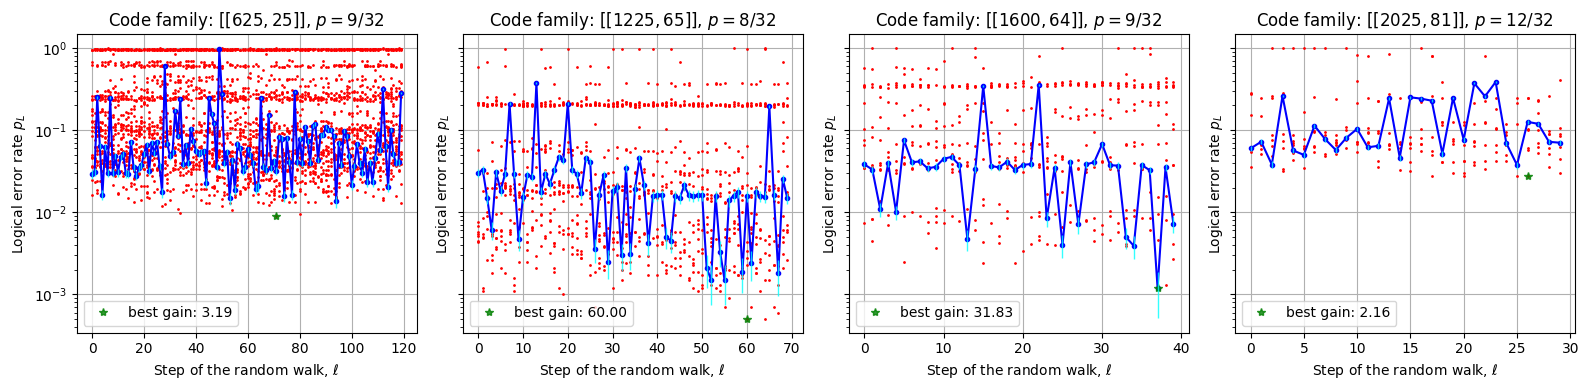

In [25]:
# fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(8,8), sharey=True)

# for code, ax, erasure_rate in zip(codes, [ax0, ax1, ax2, ax3], ['9/32', '8/32', '9/32', '12/32']):
#     data_0 = fn_data[code]
#     ax.set_title(f'Code family: $[{code}]$, $p = {erasure_rate}$')
#     x = np.arange(len(data_0['mean'].T))
#     ax.semilogy(x, data_0['mean'][1:].T, 'r.', markersize=2)
#     ax.semilogy(x, data_0['mean'][0].T, 'b.-')
#     gain = data_0['mean'][0][0]/data_0['mean'].min()
#     ax.semilogy(data_0['mean'].min(axis=0).argmin(), data_0['mean'].min(), 'g*', alpha=0.8, 
#               linewidth=1, label=f'best gain: {gain:.2f}')
#     ax.vlines(x, data_0['mean'][0].T - 1.96*data_0['std'][0]/1e2, 
#               data_0['mean'][0].T + 1.96*data_0['std'][0]/1e2, alpha=0.8, color='cyan', linewidth=1)
#     ax.set_xlabel('Step of the random walk, $\\ell$')
#     ax.set_ylabel('Logical error rate $p_L$')
#     ax.grid('minor')
#     ax.legend()
# # plt.xlim([0, 19])
# # plt.ylim([8e-3, 7e-2])
# plt.tight_layout()

# plt.savefig('../img/exploration_slides.pdf')

# plt.show()

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16,4), sharey=True)

for code, ax, erasure_rate in zip(codes, [ax0, ax1, ax2, ax3], ['9/32', '8/32', '9/32', '12/32']):
    data_0 = fn_data[code]
    ax.set_title(f'Code family: $[{code}]$, $p = {erasure_rate}$')
    x = np.arange(len(data_0['mean'].T))
    ax.semilogy(x, data_0['mean'][1:].T, 'r.', markersize=2)
    ax.semilogy(x, data_0['mean'][0].T, 'b.-')
    gain = data_0['mean'][0][0]/data_0['mean'].min()
    ax.semilogy(data_0['mean'].min(axis=0).argmin(), data_0['mean'].min(), 'g*', alpha=0.8, 
              linewidth=1, label=f'best gain: {gain:.2f}')
    ax.vlines(x, data_0['mean'][0].T - 1.96*data_0['std'][0]/1e2, 
              data_0['mean'][0].T + 1.96*data_0['std'][0]/1e2, alpha=0.8, color='cyan', linewidth=1)
    ax.set_xlabel('Step of the random walk, $\\ell$')
    ax.set_ylabel('Logical error rate $p_L$')
    ax.grid('minor')
    ax.legend()
# plt.xlim([0, 19])
# plt.ylim([8e-3, 7e-2])
plt.tight_layout()

# plt.savefig('../img/exploration.pdf')

plt.show()

In [26]:
[fn_data[code]['mean'][0,0] for code in codes], [fn_data[code]['mean'].min() for code in codes]

([0.029, 0.03, 0.0382, 0.0597], [0.0091, 0.0005, 0.0012, 0.0277])

In [27]:
[fn_data[code]['mean'].max() for code in codes]

[0.9987, 0.9845, 0.9982, 1.0]

In [28]:
[np.abs(fn_data[code]['mean'][1:] - fn_data[code]['mean'][0]).max() for code in codes]

[0.9654, 0.9714, 0.9914, 0.962]

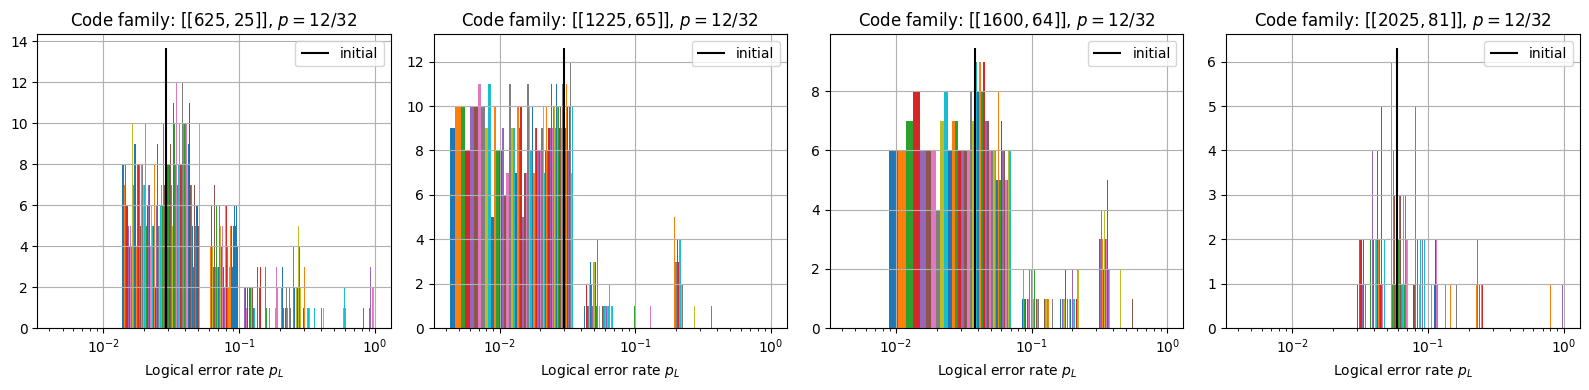

In [30]:
# fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(8,8), sharex=True)

# for code, ax in zip(codes, [ax0, ax1, ax2, ax3]):
#     ax.set_title(f'Code family: $[{code}]$, $p = {erasure_rate}$')
#     ax.set_xscale('log')
#     ax.hist(fn_data[code]['mean'], bins='auto')
#     ymin, ymax = ax.get_ylim()
#     ax.vlines(x=fn_data[code]['mean'][0][0], ymin=ymin, ymax=ymax, 
#               label='initial', color='k')
#     ax.set_xlabel('Logical error rate $p_L$')
#     ax.grid('minor')
#     ax.legend()
#     # ax.plot(np.abs(fn_data[code]['mean'][1:] - fn_data[code]['mean'][0]).max(axis=0))

# plt.tight_layout()

# plt.savefig('../img/histexplore_slides.pdf')

# plt.show()

fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(16,4), sharex=True)

for code, ax in zip(codes, [ax0, ax1, ax2, ax3]):
    ax.set_title(f'Code family: $[{code}]$, $p = {erasure_rate}$')
    ax.set_xscale('log')
    ax.hist(fn_data[code]['mean'], bins='auto')
    ymin, ymax = ax.get_ylim()
    ax.vlines(x=fn_data[code]['mean'][0][0], ymin=ymin, ymax=ymax, 
              label='initial', color='k')
    ax.set_xlabel('Logical error rate $p_L$')
    ax.grid('minor')
    ax.legend()
    # ax.plot(np.abs(fn_data[code]['mean'][1:] - fn_data[code]['mean'][0]).max(axis=0))

plt.tight_layout()

# plt.savefig('../img/histexplore.pdf')

plt.show()

In [32]:
bad_codes0 = fn_data[codes[0]]['state'][(fn_data[codes[0]]['mean'] > 0.8).flatten()]

In [33]:
badcode = from_edgelist(bad_codes0[0])

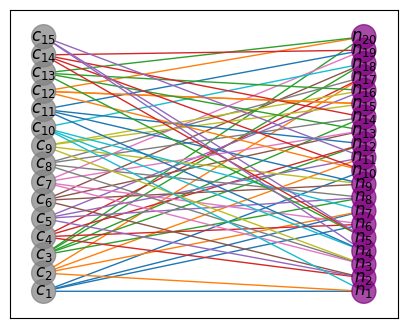

In [36]:
draw_bpt_graph(badcode)

# Projective Simulation results

In [37]:
import h5py
from experiments_settings import load_tanner_graph, parse_edgelist
from experiments_settings import codes, path_to_initial_codes, textfiles
from experiments_settings import MC_budget, noise_levels

from train import ps_params

hard_data = {}
with h5py.File('ps_train.hdf5', 'r') as f:
    for code, grp in f.items():
        subgrp = grp['hard']
        hard_data[code] = {}
        for beg, subsubgrp in subgrp.items():
            hard_data[code][beg] = {}
            hard_data[code][beg]['beta'] = subsubgrp.attrs['beta']
            hard_data[code][beg]['eta'] = subsubgrp.attrs['eta']
            hard_data[code][beg]['gamma'] = subsubgrp.attrs['gamma']
            hard_data[code][beg]['costs'] = subsubgrp['costs'][()]
            hard_data[code][beg]['states'] = subsubgrp['states'][()]
            hard_data[code][beg]['ep_len'] = subsubgrp['ep_len'][()]


easy_data = {}
with h5py.File('ps_train.hdf5', 'r') as f:
    for code, grp in f.items():
        subgrp = grp['easy']
        easy_data[code] = {}
        for beg, subsubgrp in subgrp.items():
            easy_data[code][beg] = {}
            easy_data[code][beg]['beta'] = subsubgrp.attrs['beta']
            easy_data[code][beg]['eta'] = subsubgrp.attrs['eta']
            easy_data[code][beg]['gamma'] = subsubgrp.attrs['gamma']
            easy_data[code][beg]['costs'] = subsubgrp['costs'][()]
            easy_data[code][beg]['states'] = subsubgrp['states'][()]
            easy_data[code][beg]['ep_len'] = subsubgrp['ep_len'][()]
    

In [38]:
hard_data.keys(), \
hard_data[codes[0]].keys(), \
hard_data[codes[0]]['beg=000'].keys(), \
hard_data[codes[0]]['beg=000']['costs'].min()

(dict_keys(['[1225,65]', '[1600,64]', '[2025,81]', '[625,25]']),
 dict_keys(['beg=000', 'beg=001', 'beg=002', 'beg=010', 'beg=011', 'beg=012', 'beg=020', 'beg=021', 'beg=022', 'beg=100', 'beg=101', 'beg=102', 'beg=110', 'beg=111', 'beg=112', 'beg=120', 'beg=121', 'beg=122', 'beg=200', 'beg=201', 'beg=202', 'beg=210', 'beg=211', 'beg=212', 'beg=220', 'beg=221', 'beg=222']),
 dict_keys(['beta', 'eta', 'gamma', 'costs', 'states', 'ep_len']),
 0.0095)

In [39]:
best_hard_beg = {
    code: min((beg for beg in hard_data[code]), key=lambda k: hard_data[code][k]['costs'].min()) for code in codes
}
best_hard_data = {code: hard_data[code][best_hard_beg[code]] for code in codes}

best_easy_beg = {
    code: min((beg for beg in easy_data[code]), key=lambda k: easy_data[code][k]['costs'].min()) for code in codes
}
best_easy_data = {code: easy_data[code][best_easy_beg[code]] for code in codes}

In [40]:
print('Hard threshold')
print(best_hard_data.keys())

for code in codes:
    print(f'\nCode family: [{code}]')
    print(best_hard_data[code].keys())
    print(f"Best beta: {best_hard_data[code]['beta']:.3g}")
    print(f"Best eta: {best_hard_data[code]['eta']:.3g}")
    print(f"Best gamma: {best_hard_data[code]['gamma']:.3g}")
    print(f"Best cost: {best_hard_data[code]['costs'].min():.3g}")
    print(f"Initial cost: {best_hard_data[code]['costs'].flatten()[0]:.3g}")
    gain = best_hard_data[code]['costs'].flatten()[0]/best_hard_data[code]['costs'].min()
    print(f"Best gain: {gain:.3g}")

Hard threshold
dict_keys(['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]'])

Code family: [[625,25]]
dict_keys(['beta', 'eta', 'gamma', 'costs', 'states', 'ep_len'])
Best beta: 6.79
Best eta: 0.0019
Best gamma: 0.000456
Best cost: 0.0065
Initial cost: 0.0304
Best gain: 4.68

Code family: [[1225,65]]
dict_keys(['beta', 'eta', 'gamma', 'costs', 'states', 'ep_len'])
Best beta: 8.85
Best eta: 0.00243
Best gamma: 0.000561
Best cost: 0.0004
Initial cost: 0.0312
Best gain: 78

Code family: [[1600,64]]
dict_keys(['beta', 'eta', 'gamma', 'costs', 'states', 'ep_len'])
Best beta: 9.12
Best eta: 0.00158
Best gamma: 0.00172
Best cost: 0.0007
Initial cost: 0.0329
Best gain: 47

Code family: [[2025,81]]
dict_keys(['beta', 'eta', 'gamma', 'costs', 'states', 'ep_len'])
Best beta: 7.97
Best eta: 0.0026
Best gamma: 0.00286
Best cost: 0.0241
Initial cost: 0.0555
Best gain: 2.3


In [41]:
print('Easy threshold')
print(best_easy_data.keys())

for code in codes:
    print(f'\nCode family: [{code}]')
    print(best_easy_data[code].keys())
    print(f"Best beta: {best_easy_data[code]['beta']:.3g}")
    print(f"Best eta: {best_easy_data[code]['eta']:.3g}")
    print(f"Best gamma: {best_easy_data[code]['gamma']:.3g}")
    print(f"Best cost: {best_easy_data[code]['costs'].min():.3g}")
    print(f"Initial cost: {best_easy_data[code]['costs'].flatten()[0]:.3g}")
    gain = best_easy_data[code]['costs'].flatten()[0]/best_easy_data[code]['costs'].min()
    print(f"Best gain: {gain:.3g}")

Easy threshold
dict_keys(['[625,25]', '[1225,65]', '[1600,64]', '[2025,81]'])

Code family: [[625,25]]
dict_keys(['beta', 'eta', 'gamma', 'costs', 'states', 'ep_len'])
Best beta: 6.79
Best eta: 0
Best gamma: 0.000898
Best cost: 0.0072
Initial cost: 0.0307
Best gain: 4.26

Code family: [[1225,65]]
dict_keys(['beta', 'eta', 'gamma', 'costs', 'states', 'ep_len'])
Best beta: 8.16
Best eta: 0
Best gamma: 0
Best cost: 0.0006
Initial cost: 0.0324
Best gain: 54

Code family: [[1600,64]]
dict_keys(['beta', 'eta', 'gamma', 'costs', 'states', 'ep_len'])
Best beta: 8.43
Best eta: 0
Best gamma: 0
Best cost: 0.0009
Initial cost: 0.0377
Best gain: 41.9

Code family: [[2025,81]]
dict_keys(['beta', 'eta', 'gamma', 'costs', 'states', 'ep_len'])
Best beta: 8.66
Best eta: 0
Best gamma: 0
Best cost: 0.0227
Initial cost: 0.0574
Best gain: 2.53


In [42]:
ps_data = {code: max((best_hard_data[code], best_easy_data[code]), key=lambda x: x['costs'].flatten()[0]/x['costs'].min()) for code in codes}

In [15]:
# with h5py.File("best_from_ps.hdf5", "a") as f: 
#         for code, noise_lvl, txtfile in zip(codes, noise_levels, textfiles):
#             grp = f.require_group(code)
#             grp.attrs['p'] = noise_lvl
#             dset = ps_data[code]
#             states, _ = min( ( (s, c) for s, c in zip(dset['states'], dset['costs']) ), 
#                             key=lambda pair: pair[1])
#             grp.create_dataset("states", data=states)

In [43]:
with h5py.File("best_from_ps.hdf5", "r") as f: 
    for k, grp in f.items():
        print(k, grp)
        print(grp.keys())

[1225,65] <HDF5 group "/[1225,65]" (3 members)>
<KeysViewHDF5 ['mean', 'states', 'std']>
[1600,64] <HDF5 group "/[1600,64]" (3 members)>
<KeysViewHDF5 ['mean', 'states', 'std']>
[2025,81] <HDF5 group "/[2025,81]" (3 members)>
<KeysViewHDF5 ['mean', 'states', 'std']>
[625,25] <HDF5 group "/[625,25]" (3 members)>
<KeysViewHDF5 ['mean', 'states', 'std']>


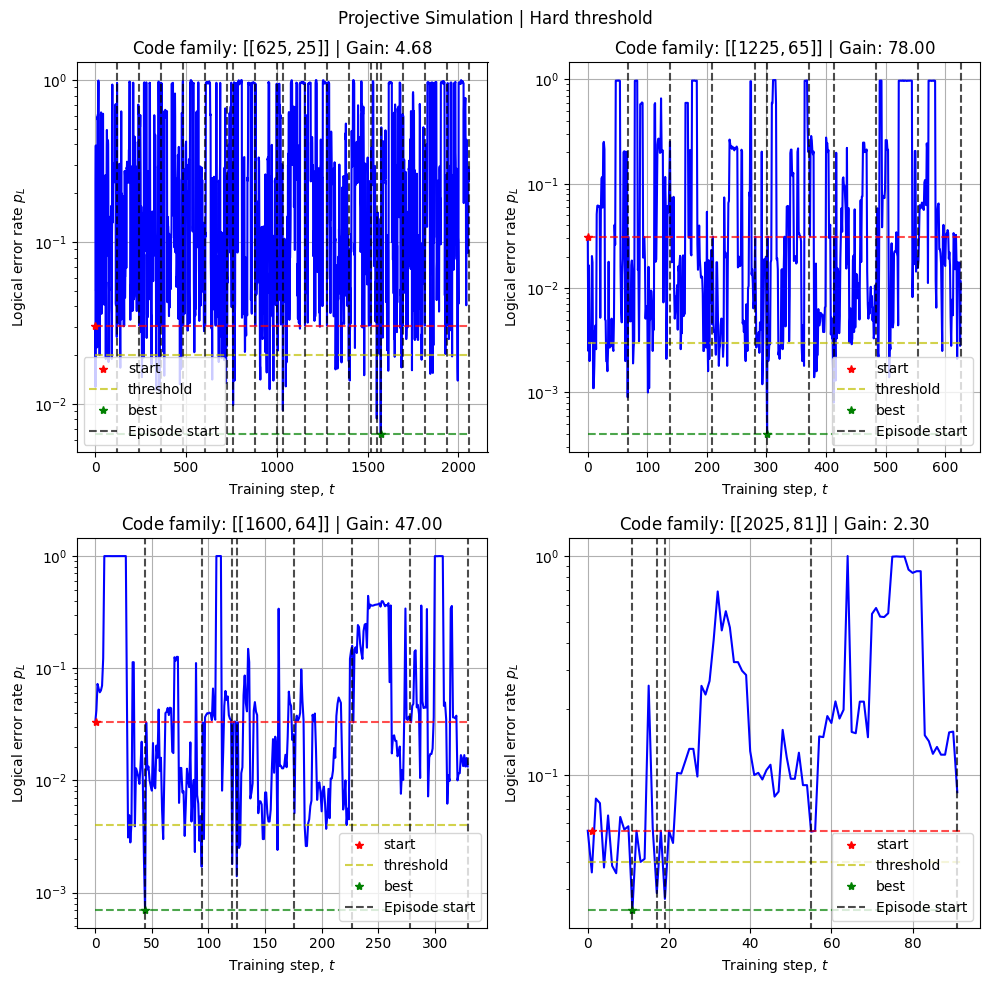

In [44]:
fig, ((ax0, ax1), 
      (ax2, ax3),) = plt.subplots(2, 2, figsize=(10,10))
plt.suptitle(f"Projective Simulation | Hard threshold")

ymin_global, ymax_global = 0, 0

for code, ax, th in zip(codes, [ax0, ax1, ax2, ax3], ps_params['plog_thres_hard']):
    cost = best_hard_data[code]['costs'].flatten()
    eplens = best_hard_data[code]['ep_len'].flatten()
    t = len(cost)
    gain = cost[0]/cost.min()
    ax.set_title(f"Code family: $[{code}]$ | Gain: {gain:.2f}")
    
    ax.semilogy(np.arange(t), cost, 'b')
    
    ax.hlines(y=cost[0], xmin=0, xmax=t, color='r', linestyle='--', alpha=0.7)
    ax.semilogy(1, cost[0], 'r*', label='start')
    
    ax.hlines(y=th, xmin=0, xmax=t, color='y', linestyle='--', alpha=0.7, label='threshold')
    
    ax.hlines(y=cost.min(), xmin=0, xmax=t, color='g', linestyle='--', alpha=0.7)
    ax.semilogy(cost.argmin(), cost.min(), 'g*', label='best')

    ymin, ymax = ax.get_ylim()
    ymin_global = min(ymin_global, ymin)
    ymax_global = max(ymax_global, ymax)
    
    ax.set_ylabel('Logical error rate $p_L$')
    ax.set_xlabel('Training step, $t$')
    ax.grid('minor')
    

for code, ax in zip(codes, [ax0, ax1, ax2, ax3]):
    eplens = best_hard_data[code]['ep_len'].flatten()
    ax.vlines(x=eplens.cumsum()-1, ymin=ymin_global, ymax=ymax_global, color='k', 
              linestyle='--', label='Episode start', alpha=0.7)
    ax.legend()


plt.tight_layout()

# plt.savefig(f'../img/PShard.pdf')
    
plt.show()

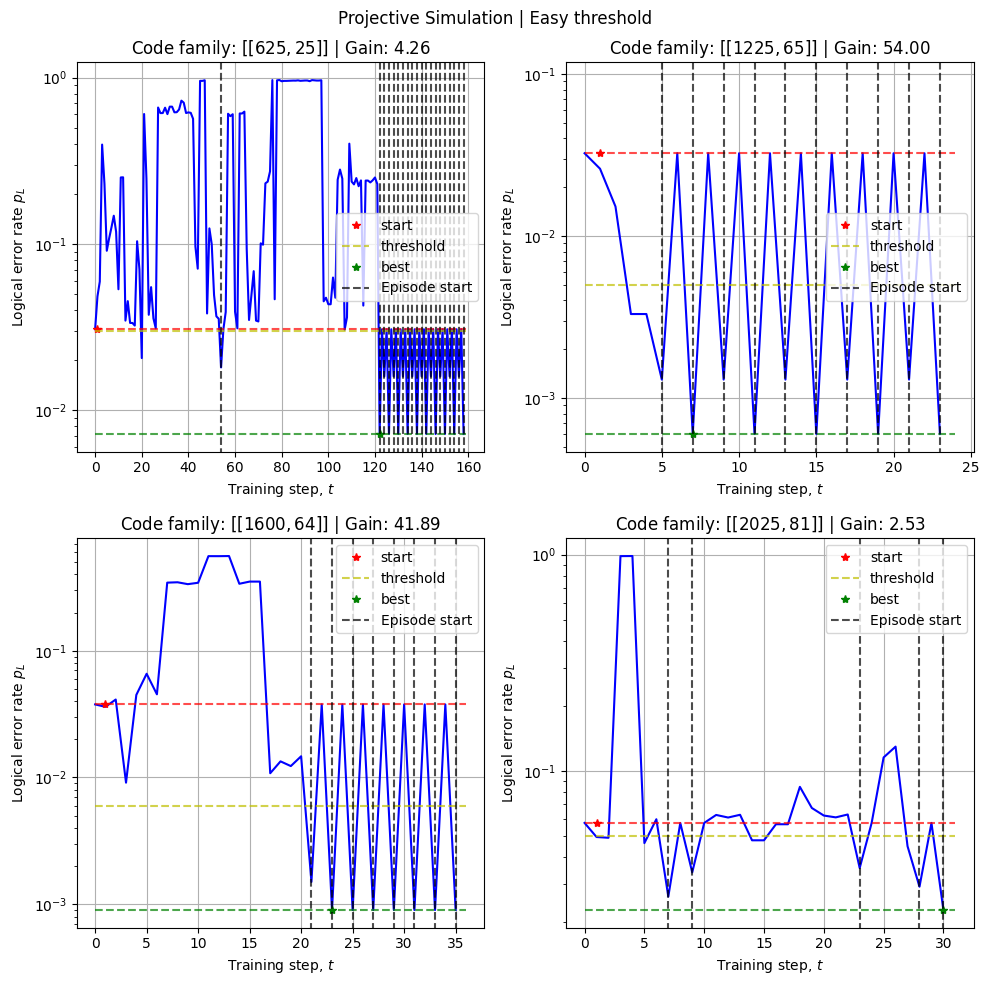

In [45]:
fig, ((ax0, ax1), 
      (ax2, ax3),) = plt.subplots(2, 2, figsize=(10,10))
plt.suptitle(f"Projective Simulation | Easy threshold")

ymin_global, ymax_global = 0, 0

for code, ax, th in zip(codes, [ax0, ax1, ax2, ax3], ps_params['plog_thres_easy']):
    cost = best_easy_data[code]['costs'].flatten()
    eplens = best_easy_data[code]['ep_len'].flatten()
    t = len(cost)
    gain = cost[0]/cost.min()
    ax.set_title(f"Code family: $[{code}]$ | Gain: {gain:.2f}")
    
    ax.semilogy(np.arange(t), cost, 'b')
    
    ax.hlines(y=cost[0], xmin=0, xmax=t, color='r', linestyle='--', alpha=0.7)
    ax.semilogy(1, cost[0], 'r*', label='start')
    
    ax.hlines(y=th, xmin=0, xmax=t, color='y', linestyle='--', alpha=0.7, label='threshold')
    
    ax.hlines(y=cost.min(), xmin=0, xmax=t, color='g', linestyle='--', alpha=0.7)
    ax.semilogy(cost.argmin(), cost.min(), 'g*', label='best')

    ymin, ymax = ax.get_ylim()
    ymin_global = min(ymin_global, ymin)
    ymax_global = max(ymax_global, ymax)
    
    ax.set_ylabel('Logical error rate $p_L$')
    ax.set_xlabel('Training step, $t$')
    ax.grid('minor')
    

for code, ax in zip(codes, [ax0, ax1, ax2, ax3]):
    eplens = best_easy_data[code]['ep_len'].flatten()
    ax.vlines(x=eplens.cumsum()-1, ymin=ymin_global, ymax=ymax_global, color='k', 
              linestyle='--', label='Episode start', alpha=0.7)
    ax.legend()


plt.tight_layout()

# plt.savefig(f'../img/PSeasy.pdf')
    
plt.show()